In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.4


# Gaussian process models for stellar variability

When fitting exoplanets, we also need to fit for the stellar variability and Gaussian Processes (GPs) are often a good descriptive model for this variation.
[PyMC3 has support for all sorts of general GP models](https://docs.pymc.io/gp.html), but *exoplanet* includes support for scalable 1D GPs (see :ref:`gp` for more info) that can work with large datasets.
In this tutorial, we go through the process of modeling the light curve of a rotating star observed by Kepler using *exoplanet*.

First, let's download and plot the data:

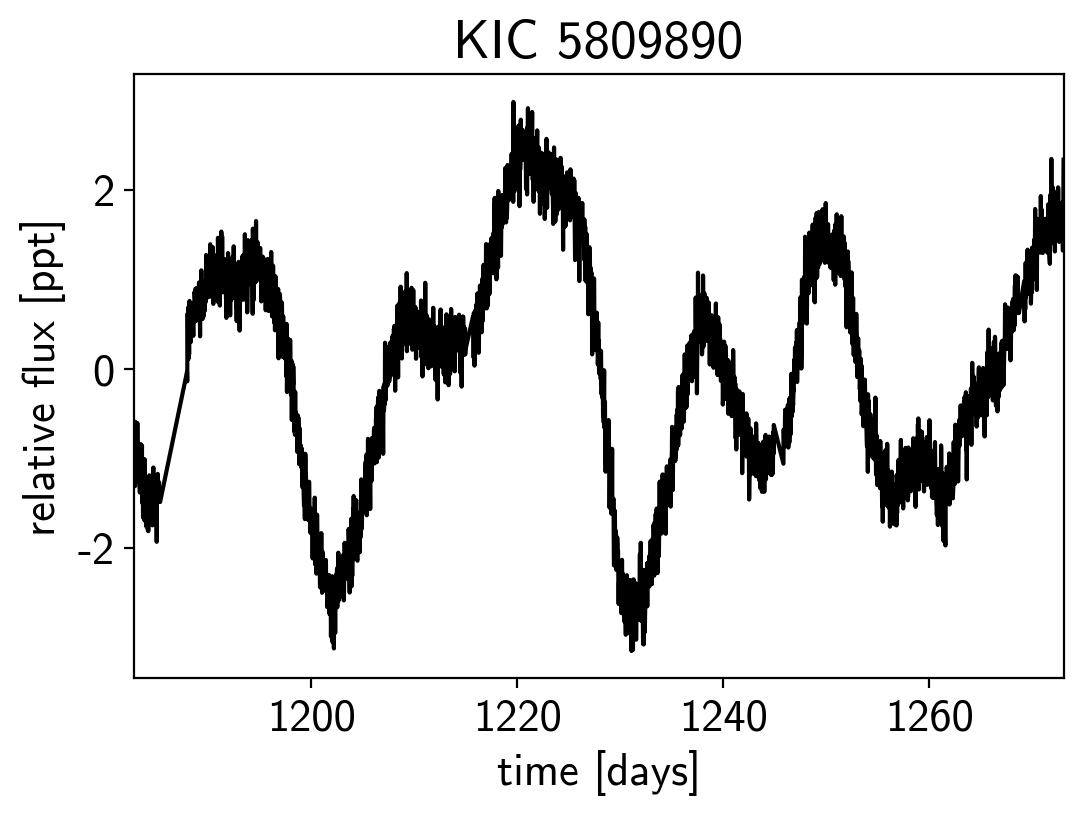

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

url = "https://archive.stsci.edu/missions/kepler/lightcurves/0058/005809890/kplr005809890-2012179063303_llc.fits"
with fits.open(url) as hdus:
    data = hdus[1].data
    
x = data["TIME"]
y = data["PDCSAP_FLUX"]
yerr = data["PDCSAP_FLUX_ERR"]
m = (data["SAP_QUALITY"] == 0) & np.isfinite(x) & np.isfinite(y)

x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
yerr = np.ascontiguousarray(yerr[m], dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

plt.plot(x, y, "k")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890");

## A Gaussian process model for stellar variability

This looks like the light curve of a rotating star, and [it has been shown](https://arxiv.org/abs/1706.05459) that it is possible to model this variability by using a quasiperiodic Gaussian process.
To start with, let's get an estimate of the rotation period using the Lomb-Scargle periodogram:

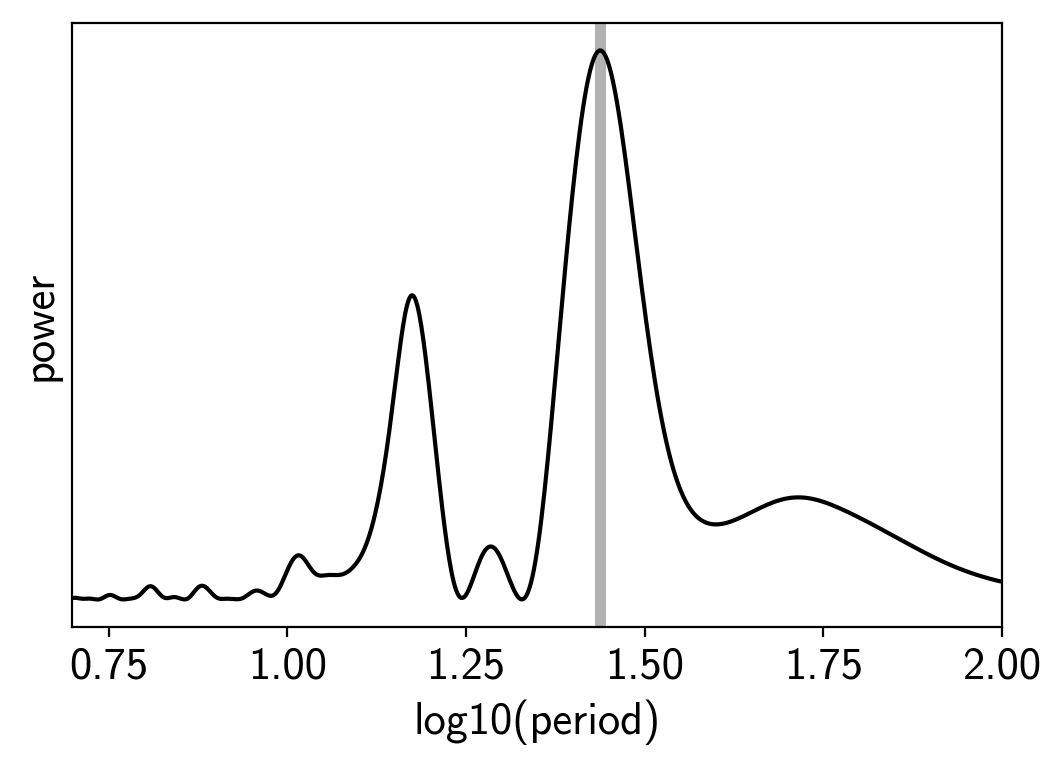

In [4]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=5.0, max_period=100.0,
    samples_per_peak=50)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(peak["period"]), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");

Now, using this initialization, we can set up the GP model in *exoplanet*.
We'll use the :class:`exoplanet.gp.terms.RotationTerm` kernel that is a mixture of two simple harmonic oscillators with periods separated by a factor of two.
As you can see from the periodogram above, this might be a good model for this light curve and I've found that it works well in many cases.

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    
    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)
    
    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr)), sd=5.0)
    
    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
    logperiod = pm.Normal("logperiod", mu=np.log(peak["period"]), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = pm.Uniform("mix", lower=0, upper=1.0)
    
    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))
    
    # Set up the Gaussian Process model
    kernel = xo.gp.terms.RotationTerm(
        log_amp=logamp,
        period=period,
        log_Q0=logQ0,
        log_deltaQ=logdeltaQ,
        mix=mix
    )
    gp = xo.gp.GP(kernel, x, yerr**2 + tt.exp(logs2), J=4)
    
    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    pm.Potential("loglike", gp.log_likelihood(y - mean))
    
    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())
    
    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

success: True
initial logp: 509.6137787809487
final logp: 692.9546941343992


Now that we have the model set up, let's plot the maximum a posteriori model prediction.

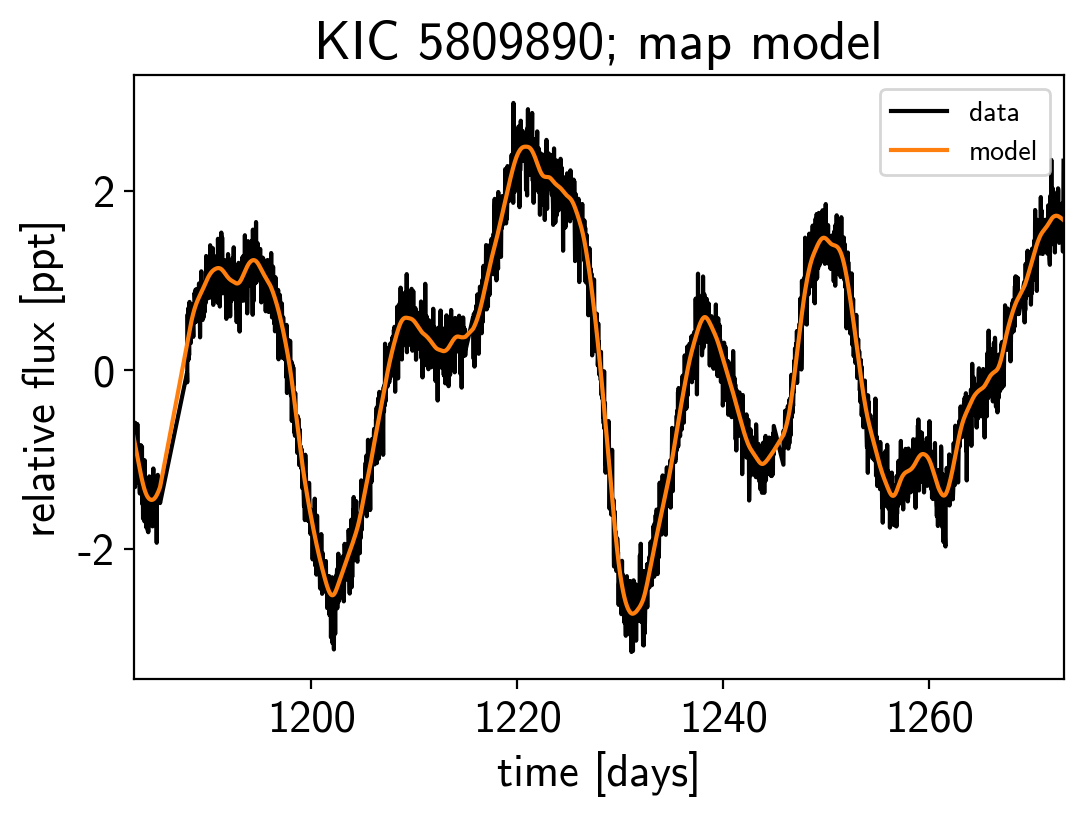

In [6]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890; map model");

That looks pretty good!
Now let's sample from the posterior using a :class:`exoplanet.PyMC3Sampler`.

In [7]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(finish=200)
with model:
    sampler.tune(tune=2000, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=2000)

Sampling 4 chains:   0%|          | 0/308 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 10/308 [00:00<00:04, 72.33draws/s]

Sampling 4 chains:   4%|▍         | 13/308 [00:00<00:10, 28.93draws/s]

Sampling 4 chains:   5%|▍         | 15/308 [00:00<00:31,  9.44draws/s]

Sampling 4 chains:   6%|▌         | 17/308 [00:01<00:26, 10.99draws/s]

Sampling 4 chains:   7%|▋         | 21/308 [00:01<00:22, 12.90draws/s]

Sampling 4 chains:   7%|▋         | 23/308 [00:01<00:36,  7.88draws/s]

Sampling 4 chains:   8%|▊         | 26/308 [00:02<00:34,  8.14draws/s]

Sampling 4 chains:   9%|▉         | 28/308 [00:02<00:28,  9.74draws/s]

Sampling 4 chains:  10%|▉         | 30/308 [00:02<00:29,  9.46draws/s]

Sampling 4 chains:  10%|█         | 32/308 [00:02<00:27, 10.13draws/s]

Sampling 4 chains:  11%|█▏        | 35/308 [00:02<00:26, 10.14draws/s]

Sampling 4 chains:  13%|█▎        | 39/308 [00:02<00:21, 12.76draws/s]

Sampling 4 chains:  14%|█▎        | 42/308 [00:03<00:18, 14.01draws/s]

Sampling 4 chains:  14%|█▍        | 44/308 [00:03<00:18, 14.10draws/s]

Sampling 4 chains:  16%|█▌        | 48/308 [00:03<00:16, 15.30draws/s]

Sampling 4 chains:  16%|█▌        | 50/308 [00:03<00:17, 14.79draws/s]

Sampling 4 chains:  17%|█▋        | 52/308 [00:03<00:19, 13.23draws/s]

Sampling 4 chains:  18%|█▊        | 54/308 [00:03<00:18, 13.37draws/s]

Sampling 4 chains:  18%|█▊        | 56/308 [00:04<00:19, 12.71draws/s]

Sampling 4 chains:  19%|█▉        | 58/308 [00:04<00:23, 10.74draws/s]

Sampling 4 chains:  19%|█▉        | 60/308 [00:04<00:20, 12.35draws/s]

Sampling 4 chains:  20%|██        | 62/308 [00:04<00:18, 13.33draws/s]

Sampling 4 chains:  21%|██▏       | 66/308 [00:04<00:14, 16.21draws/s]

Sampling 4 chains:  22%|██▏       | 69/308 [00:04<00:15, 15.05draws/s]

Sampling 4 chains:  23%|██▎       | 71/308 [00:05<00:14, 15.83draws/s]

Sampling 4 chains:  24%|██▎       | 73/308 [00:05<00:17, 13.33draws/s]

Sampling 4 chains:  24%|██▍       | 75/308 [00:05<00:16, 13.91draws/s]

Sampling 4 chains:  25%|██▌       | 78/308 [00:05<00:16, 14.17draws/s]

Sampling 4 chains:  26%|██▋       | 81/308 [00:05<00:15, 14.43draws/s]

Sampling 4 chains:  27%|██▋       | 83/308 [00:06<00:17, 12.67draws/s]

Sampling 4 chains:  28%|██▊       | 86/308 [00:06<00:15, 13.91draws/s]

Sampling 4 chains:  29%|██▊       | 88/308 [00:06<00:15, 14.09draws/s]

Sampling 4 chains:  30%|██▉       | 92/308 [00:06<00:12, 16.91draws/s]

Sampling 4 chains:  31%|███       | 94/308 [00:06<00:16, 12.99draws/s]

Sampling 4 chains:  32%|███▏      | 98/308 [00:06<00:13, 16.08draws/s]

Sampling 4 chains:  33%|███▎      | 102/308 [00:06<00:10, 19.11draws/s]

Sampling 4 chains:  34%|███▍      | 105/308 [00:07<00:11, 18.29draws/s]

Sampling 4 chains:  35%|███▌      | 108/308 [00:07<00:10, 18.98draws/s]

Sampling 4 chains:  36%|███▌      | 111/308 [00:07<00:11, 17.15draws/s]

Sampling 4 chains:  37%|███▋      | 114/308 [00:07<00:10, 17.78draws/s]

Sampling 4 chains:  38%|███▊      | 117/308 [00:07<00:11, 16.08draws/s]

Sampling 4 chains:  39%|███▊      | 119/308 [00:08<00:17, 10.87draws/s]

Sampling 4 chains:  39%|███▉      | 121/308 [00:08<00:15, 12.17draws/s]

Sampling 4 chains:  40%|███▉      | 123/308 [00:08<00:15, 12.13draws/s]

Sampling 4 chains:  41%|████      | 125/308 [00:08<00:17, 10.26draws/s]

Sampling 4 chains:  41%|████      | 127/308 [00:08<00:16, 10.80draws/s]

Sampling 4 chains:  42%|████▏     | 130/308 [00:09<00:15, 11.74draws/s]

Sampling 4 chains:  43%|████▎     | 132/308 [00:09<00:13, 12.59draws/s]

Sampling 4 chains:  44%|████▎     | 134/308 [00:09<00:15, 11.43draws/s]

Sampling 4 chains:  44%|████▍     | 137/308 [00:09<00:12, 14.00draws/s]

Sampling 4 chains:  45%|████▌     | 139/308 [00:09<00:11, 15.19draws/s]

Sampling 4 chains:  46%|████▌     | 141/308 [00:09<00:15, 10.73draws/s]

Sampling 4 chains:  47%|████▋     | 145/308 [00:10<00:13, 12.14draws/s]

Sampling 4 chains:  48%|████▊     | 147/308 [00:10<00:13, 11.90draws/s]

Sampling 4 chains:  48%|████▊     | 149/308 [00:10<00:12, 12.25draws/s]

Sampling 4 chains:  49%|████▉     | 151/308 [00:10<00:12, 12.21draws/s]

Sampling 4 chains:  50%|█████     | 155/308 [00:10<00:10, 15.00draws/s]

Sampling 4 chains:  51%|█████     | 157/308 [00:10<00:09, 16.21draws/s]

Sampling 4 chains:  52%|█████▏    | 159/308 [00:11<00:09, 16.22draws/s]

Sampling 4 chains:  53%|█████▎    | 163/308 [00:11<00:07, 19.53draws/s]

Sampling 4 chains:  54%|█████▍    | 166/308 [00:11<00:07, 18.61draws/s]

Sampling 4 chains:  55%|█████▍    | 169/308 [00:11<00:10, 13.50draws/s]

Sampling 4 chains:  56%|█████▌    | 171/308 [00:11<00:09, 14.55draws/s]

Sampling 4 chains:  57%|█████▋    | 175/308 [00:11<00:07, 16.68draws/s]

Sampling 4 chains:  58%|█████▊    | 178/308 [00:12<00:07, 18.02draws/s]

Sampling 4 chains:  59%|█████▉    | 181/308 [00:12<00:10, 11.99draws/s]

Sampling 4 chains:  59%|█████▉    | 183/308 [00:12<00:11, 11.20draws/s]

Sampling 4 chains:  60%|██████    | 185/308 [00:12<00:11, 10.32draws/s]

Sampling 4 chains:  61%|██████    | 187/308 [00:13<00:10, 11.74draws/s]

Sampling 4 chains:  62%|██████▏   | 190/308 [00:13<00:08, 13.85draws/s]

Sampling 4 chains:  62%|██████▏   | 192/308 [00:13<00:08, 12.96draws/s]

Sampling 4 chains:  63%|██████▎   | 194/308 [00:13<00:08, 13.07draws/s]

Sampling 4 chains:  64%|██████▎   | 196/308 [00:13<00:08, 13.30draws/s]

Sampling 4 chains:  64%|██████▍   | 198/308 [00:14<00:12,  9.05draws/s]

Sampling 4 chains:  65%|██████▌   | 201/308 [00:14<00:09, 11.21draws/s]

Sampling 4 chains:  66%|██████▌   | 203/308 [00:14<00:09, 11.52draws/s]

Sampling 4 chains:  67%|██████▋   | 205/308 [00:14<00:12,  8.56draws/s]

Sampling 4 chains:  67%|██████▋   | 207/308 [00:14<00:11,  8.59draws/s]

Sampling 4 chains:  68%|██████▊   | 209/308 [00:15<00:10,  9.42draws/s]

Sampling 4 chains:  69%|██████▊   | 211/308 [00:15<00:09, 10.13draws/s]

Sampling 4 chains:  69%|██████▉   | 213/308 [00:15<00:08, 11.80draws/s]

Sampling 4 chains:  70%|███████   | 216/308 [00:15<00:06, 13.21draws/s]

Sampling 4 chains:  71%|███████▏  | 220/308 [00:15<00:05, 16.14draws/s]

Sampling 4 chains:  72%|███████▏  | 223/308 [00:15<00:05, 15.40draws/s]

Sampling 4 chains:  73%|███████▎  | 225/308 [00:16<00:05, 14.94draws/s]

Sampling 4 chains:  74%|███████▎  | 227/308 [00:16<00:05, 15.31draws/s]

Sampling 4 chains:  74%|███████▍  | 229/308 [00:16<00:04, 16.37draws/s]

Sampling 4 chains:  75%|███████▌  | 231/308 [00:16<00:04, 17.19draws/s]

Sampling 4 chains:  76%|███████▌  | 233/308 [00:16<00:06, 10.97draws/s]

Sampling 4 chains:  76%|███████▋  | 235/308 [00:16<00:07, 10.21draws/s]

Sampling 4 chains:  78%|███████▊  | 239/308 [00:17<00:05, 13.04draws/s]

Sampling 4 chains:  79%|███████▊  | 242/308 [00:17<00:05, 11.88draws/s]

Sampling 4 chains:  79%|███████▉  | 244/308 [00:17<00:04, 13.18draws/s]

Sampling 4 chains:  80%|████████  | 247/308 [00:17<00:04, 13.96draws/s]

Sampling 4 chains:  81%|████████  | 250/308 [00:17<00:03, 15.52draws/s]

Sampling 4 chains:  82%|████████▏ | 252/308 [00:17<00:04, 13.85draws/s]

Sampling 4 chains:  82%|████████▏ | 254/308 [00:18<00:05, 10.72draws/s]

Sampling 4 chains:  83%|████████▎ | 256/308 [00:18<00:04, 11.70draws/s]

Sampling 4 chains:  84%|████████▍ | 258/308 [00:18<00:04, 11.33draws/s]

Sampling 4 chains:  84%|████████▍ | 260/308 [00:19<00:06,  7.60draws/s]

Sampling 4 chains:  85%|████████▌ | 262/308 [00:19<00:04,  9.32draws/s]

Sampling 4 chains:  86%|████████▋ | 266/308 [00:19<00:03, 11.63draws/s]

Sampling 4 chains:  87%|████████▋ | 269/308 [00:19<00:02, 13.79draws/s]

Sampling 4 chains:  88%|████████▊ | 272/308 [00:19<00:03, 10.56draws/s]

Sampling 4 chains:  89%|████████▉ | 275/308 [00:19<00:02, 13.03draws/s]

Sampling 4 chains:  90%|████████▉ | 277/308 [00:20<00:03, 10.26draws/s]

Sampling 4 chains:  91%|█████████ | 279/308 [00:20<00:02, 10.77draws/s]

Sampling 4 chains:  92%|█████████▏| 282/308 [00:20<00:01, 13.21draws/s]

Sampling 4 chains:  92%|█████████▏| 284/308 [00:20<00:01, 13.54draws/s]

Sampling 4 chains:  93%|█████████▎| 286/308 [00:21<00:02,  8.87draws/s]

Sampling 4 chains:  94%|█████████▎| 288/308 [00:21<00:02,  8.33draws/s]

Sampling 4 chains:  94%|█████████▍| 290/308 [00:21<00:01, 10.02draws/s]

Sampling 4 chains:  95%|█████████▍| 292/308 [00:21<00:01, 10.04draws/s]

Sampling 4 chains:  95%|█████████▌| 294/308 [00:21<00:01,  9.96draws/s]

Sampling 4 chains:  96%|█████████▌| 296/308 [00:22<00:01,  8.47draws/s]

Sampling 4 chains:  97%|█████████▋| 298/308 [00:22<00:01,  7.34draws/s]

Sampling 4 chains:  97%|█████████▋| 299/308 [00:22<00:01,  5.22draws/s]

Sampling 4 chains:  97%|█████████▋| 300/308 [00:23<00:01,  4.08draws/s]

Sampling 4 chains:  98%|█████████▊| 301/308 [00:23<00:01,  3.86draws/s]

Sampling 4 chains:  98%|█████████▊| 302/308 [00:23<00:01,  3.96draws/s]

Sampling 4 chains:  99%|█████████▊| 304/308 [00:24<00:00,  4.13draws/s]

Sampling 4 chains:  99%|█████████▉| 305/308 [00:24<00:00,  4.54draws/s]

Sampling 4 chains:  99%|█████████▉| 306/308 [00:24<00:00,  5.06draws/s]

Sampling 4 chains: 100%|█████████▉| 307/308 [00:24<00:00,  4.73draws/s]

Sampling 4 chains: 100%|██████████| 308/308 [00:25<00:00,  3.13draws/s]

Sampling 4 chains:   0%|          | 0/108 [00:00<?, ?draws/s]

Sampling 4 chains:   9%|▉         | 10/108 [00:00<00:01, 91.64draws/s]

Sampling 4 chains:  13%|█▎        | 14/108 [00:00<00:01, 57.69draws/s]

Sampling 4 chains:  16%|█▌        | 17/108 [00:00<00:02, 42.80draws/s]

Sampling 4 chains:  19%|█▊        | 20/108 [00:00<00:05, 16.25draws/s]

Sampling 4 chains:  22%|██▏       | 24/108 [00:01<00:04, 17.23draws/s]

Sampling 4 chains:  25%|██▌       | 27/108 [00:01<00:04, 17.35draws/s]

Sampling 4 chains:  28%|██▊       | 30/108 [00:01<00:06, 12.81draws/s]

Sampling 4 chains:  30%|██▉       | 32/108 [00:01<00:05, 14.29draws/s]

Sampling 4 chains:  33%|███▎      | 36/108 [00:01<00:04, 17.12draws/s]

Sampling 4 chains:  36%|███▌      | 39/108 [00:02<00:04, 14.63draws/s]

Sampling 4 chains:  39%|███▉      | 42/108 [00:02<00:04, 16.19draws/s]

Sampling 4 chains:  41%|████      | 44/108 [00:02<00:05, 11.75draws/s]

Sampling 4 chains:  44%|████▎     | 47/108 [00:02<00:04, 13.46draws/s]

Sampling 4 chains:  46%|████▋     | 50/108 [00:02<00:03, 14.69draws/s]

Sampling 4 chains:  49%|████▉     | 53/108 [00:02<00:03, 15.87draws/s]

Sampling 4 chains:  51%|█████     | 55/108 [00:03<00:03, 14.60draws/s]

Sampling 4 chains:  55%|█████▍    | 59/108 [00:03<00:03, 16.26draws/s]

Sampling 4 chains:  56%|█████▋    | 61/108 [00:03<00:03, 14.86draws/s]

Sampling 4 chains:  58%|█████▊    | 63/108 [00:03<00:04,  9.79draws/s]

Sampling 4 chains:  60%|██████    | 65/108 [00:03<00:04, 10.36draws/s]

Sampling 4 chains:  64%|██████▍   | 69/108 [00:04<00:02, 13.06draws/s]

Sampling 4 chains:  66%|██████▌   | 71/108 [00:04<00:03, 11.86draws/s]

Sampling 4 chains:  68%|██████▊   | 73/108 [00:04<00:02, 12.98draws/s]

Sampling 4 chains:  71%|███████▏  | 77/108 [00:04<00:02, 15.09draws/s]

Sampling 4 chains:  75%|███████▌  | 81/108 [00:04<00:01, 16.91draws/s]

Sampling 4 chains:  78%|███████▊  | 84/108 [00:05<00:01, 14.29draws/s]

Sampling 4 chains:  80%|███████▉  | 86/108 [00:05<00:01, 15.03draws/s]

Sampling 4 chains:  81%|████████▏ | 88/108 [00:05<00:01, 15.23draws/s]

Sampling 4 chains:  83%|████████▎ | 90/108 [00:05<00:01, 15.56draws/s]

Sampling 4 chains:  86%|████████▌ | 93/108 [00:05<00:00, 16.23draws/s]

Sampling 4 chains:  89%|████████▉ | 96/108 [00:05<00:00, 14.23draws/s]

Sampling 4 chains:  91%|█████████ | 98/108 [00:05<00:00, 14.82draws/s]

Sampling 4 chains:  93%|█████████▎| 100/108 [00:06<00:00, 13.71draws/s]

Sampling 4 chains:  96%|█████████▋| 104/108 [00:06<00:00, 12.07draws/s]

Sampling 4 chains:  98%|█████████▊| 106/108 [00:06<00:00,  9.21draws/s]

Sampling 4 chains: 100%|██████████| 108/108 [00:07<00:00, 15.43draws/s]

Sampling 4 chains:   0%|          | 0/208 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 7/208 [00:00<00:02, 67.44draws/s]

Sampling 4 chains:   8%|▊         | 16/208 [00:00<00:02, 69.60draws/s]

Sampling 4 chains:  13%|█▎        | 27/208 [00:00<00:02, 76.35draws/s]

Sampling 4 chains:  17%|█▋        | 35/208 [00:00<00:02, 69.21draws/s]

Sampling 4 chains:  20%|█▉        | 41/208 [00:00<00:02, 61.38draws/s]

Sampling 4 chains:  23%|██▎       | 47/208 [00:00<00:03, 51.00draws/s]

Sampling 4 chains:  26%|██▌       | 54/208 [00:00<00:02, 54.65draws/s]

Sampling 4 chains:  29%|██▉       | 61/208 [00:00<00:02, 55.75draws/s]

Sampling 4 chains:  35%|███▍      | 72/208 [00:01<00:02, 63.35draws/s]

Sampling 4 chains:  38%|███▊      | 79/208 [00:01<00:01, 65.01draws/s]

Sampling 4 chains:  41%|████▏     | 86/208 [00:01<00:01, 63.19draws/s]

Sampling 4 chains:  45%|████▌     | 94/208 [00:01<00:01, 62.34draws/s]

Sampling 4 chains:  49%|████▊     | 101/208 [00:01<00:01, 54.06draws/s]

Sampling 4 chains:  52%|█████▏    | 108/208 [00:01<00:01, 55.22draws/s]

Sampling 4 chains:  56%|█████▌    | 116/208 [00:01<00:01, 60.40draws/s]

Sampling 4 chains:  60%|██████    | 125/208 [00:01<00:01, 66.49draws/s]

Sampling 4 chains:  64%|██████▍   | 133/208 [00:02<00:01, 68.48draws/s]

Sampling 4 chains:  68%|██████▊   | 141/208 [00:02<00:01, 63.58draws/s]

Sampling 4 chains:  71%|███████   | 148/208 [00:02<00:00, 62.22draws/s]

Sampling 4 chains:  75%|███████▌  | 156/208 [00:02<00:00, 62.94draws/s]

Sampling 4 chains:  79%|███████▉  | 164/208 [00:02<00:00, 62.33draws/s]

Sampling 4 chains:  82%|████████▏ | 171/208 [00:02<00:00, 64.04draws/s]

Sampling 4 chains:  86%|████████▌ | 178/208 [00:02<00:00, 55.08draws/s]

Sampling 4 chains:  89%|████████▉ | 185/208 [00:02<00:00, 56.14draws/s]

Sampling 4 chains:  92%|█████████▏| 191/208 [00:03<00:00, 56.65draws/s]

Sampling 4 chains:  95%|█████████▍| 197/208 [00:03<00:00, 51.66draws/s]

Sampling 4 chains:  98%|█████████▊| 203/208 [00:03<00:00, 39.02draws/s]

Sampling 4 chains: 100%|██████████| 208/208 [00:03<00:00, 32.75draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 9/408 [00:00<00:05, 79.19draws/s]

Sampling 4 chains:   4%|▍         | 17/408 [00:00<00:04, 78.81draws/s]

Sampling 4 chains:   6%|▌         | 23/408 [00:00<00:05, 67.58draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:05, 63.82draws/s]

Sampling 4 chains:   9%|▉         | 36/408 [00:00<00:06, 60.45draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:00<00:05, 61.14draws/s]

Sampling 4 chains:  12%|█▏        | 50/408 [00:00<00:05, 62.54draws/s]

Sampling 4 chains:  14%|█▍        | 59/408 [00:00<00:05, 68.54draws/s]

Sampling 4 chains:  16%|█▌        | 66/408 [00:00<00:05, 68.21draws/s]

Sampling 4 chains:  18%|█▊        | 73/408 [00:01<00:05, 57.64draws/s]

Sampling 4 chains:  19%|█▉        | 79/408 [00:01<00:05, 55.39draws/s]

Sampling 4 chains:  21%|██        | 85/408 [00:01<00:06, 52.52draws/s]

Sampling 4 chains:  23%|██▎       | 93/408 [00:01<00:05, 55.66draws/s]

Sampling 4 chains:  25%|██▌       | 103/408 [00:01<00:04, 64.19draws/s]

Sampling 4 chains:  27%|██▋       | 110/408 [00:01<00:04, 61.13draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:01<00:04, 62.20draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:02<00:05, 54.67draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:02<00:04, 58.04draws/s]

Sampling 4 chains:  34%|███▍      | 138/408 [00:02<00:05, 52.18draws/s]

Sampling 4 chains:  35%|███▌      | 144/408 [00:02<00:05, 47.31draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [00:02<00:04, 53.40draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [00:02<00:04, 57.32draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:02<00:04, 59.52draws/s]

Sampling 4 chains:  43%|████▎     | 174/408 [00:02<00:03, 58.72draws/s]

Sampling 4 chains:  44%|████▍     | 181/408 [00:03<00:03, 61.45draws/s]

Sampling 4 chains:  47%|████▋     | 190/408 [00:03<00:03, 67.58draws/s]

Sampling 4 chains:  49%|████▊     | 198/408 [00:03<00:03, 67.52draws/s]

Sampling 4 chains:  50%|█████     | 206/408 [00:03<00:02, 69.24draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:03<00:02, 71.43draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [00:03<00:02, 62.92draws/s]

Sampling 4 chains:  56%|█████▌    | 229/408 [00:03<00:02, 61.55draws/s]

Sampling 4 chains:  58%|█████▊    | 238/408 [00:03<00:02, 67.49draws/s]

Sampling 4 chains:  60%|██████    | 246/408 [00:03<00:02, 69.03draws/s]

Sampling 4 chains:  62%|██████▏   | 254/408 [00:04<00:02, 62.66draws/s]

Sampling 4 chains:  64%|██████▍   | 261/408 [00:04<00:02, 55.00draws/s]

Sampling 4 chains:  66%|██████▌   | 268/408 [00:04<00:02, 54.55draws/s]

Sampling 4 chains:  67%|██████▋   | 274/408 [00:04<00:02, 50.38draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [00:04<00:02, 52.57draws/s]

Sampling 4 chains:  70%|███████   | 286/408 [00:04<00:02, 54.22draws/s]

Sampling 4 chains:  72%|███████▏  | 292/408 [00:04<00:02, 47.45draws/s]

Sampling 4 chains:  73%|███████▎  | 298/408 [00:05<00:02, 45.81draws/s]

Sampling 4 chains:  75%|███████▌  | 306/408 [00:05<00:02, 50.15draws/s]

Sampling 4 chains:  77%|███████▋  | 316/408 [00:05<00:01, 57.33draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [00:05<00:01, 61.26draws/s]

Sampling 4 chains:  82%|████████▏ | 333/408 [00:05<00:01, 67.25draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [00:05<00:01, 63.17draws/s]

Sampling 4 chains:  86%|████████▌ | 349/408 [00:05<00:00, 66.98draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [00:05<00:00, 66.56draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [00:05<00:00, 69.77draws/s]

Sampling 4 chains:  91%|█████████▏| 373/408 [00:06<00:00, 64.37draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [00:06<00:00, 58.84draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [00:06<00:00, 44.72draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [00:06<00:00, 46.96draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [00:06<00:00, 46.55draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:07<00:00, 33.84draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:07<00:00, 56.21draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 8/808 [00:00<00:10, 73.67draws/s]

Sampling 4 chains:   2%|▏         | 18/808 [00:00<00:10, 78.29draws/s]

Sampling 4 chains:   3%|▎         | 26/808 [00:00<00:09, 78.59draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:00<00:11, 67.41draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:00<00:12, 62.49draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:00<00:11, 64.19draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:00<00:12, 59.48draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:00<00:11, 67.27draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:00<00:10, 67.92draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:01<00:10, 70.02draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:01<00:10, 71.66draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:01<00:10, 65.76draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:01<00:11, 62.09draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:01<00:11, 60.15draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:01<00:11, 60.51draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:01<00:10, 66.66draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:01<00:10, 63.78draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:02<00:09, 67.74draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:02<00:10, 64.84draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:02<00:10, 64.30draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:02<00:10, 63.36draws/s]

Sampling 4 chains:  21%|██        | 167/808 [00:02<00:09, 69.05draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:02<00:09, 66.86draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:02<00:08, 70.56draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:02<00:08, 76.50draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [00:02<00:08, 69.56draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:03<00:09, 63.85draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [00:03<00:08, 68.93draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [00:03<00:08, 65.77draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:03<00:09, 59.52draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:03<00:10, 55.81draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:03<00:08, 62.60draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:03<00:08, 65.52draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:03<00:08, 66.42draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:04<00:07, 73.35draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:04<00:06, 79.38draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:04<00:06, 81.61draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:04<00:06, 76.95draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:04<00:06, 82.07draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [00:04<00:05, 82.80draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:04<00:05, 85.76draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [00:04<00:05, 88.79draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [00:04<00:05, 86.21draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [00:05<00:05, 76.57draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [00:05<00:05, 74.24draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:05<00:05, 73.14draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [00:05<00:05, 72.58draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [00:05<00:05, 75.38draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [00:05<00:05, 74.46draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [00:05<00:05, 72.89draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [00:05<00:05, 73.24draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [00:06<00:05, 70.21draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [00:06<00:05, 71.08draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [00:06<00:04, 76.30draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [00:06<00:04, 73.79draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [00:06<00:04, 74.59draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [00:06<00:04, 80.59draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [00:06<00:04, 80.34draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [00:06<00:03, 84.75draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [00:06<00:03, 77.29draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [00:07<00:03, 82.54draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [00:07<00:03, 79.56draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [00:07<00:03, 81.92draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [00:07<00:03, 77.70draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [00:07<00:03, 69.94draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [00:07<00:03, 71.13draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [00:07<00:03, 67.61draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [00:07<00:02, 77.37draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [00:08<00:02, 80.72draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [00:08<00:02, 82.74draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [00:08<00:02, 79.60draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [00:08<00:02, 80.53draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [00:08<00:02, 82.75draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [00:08<00:01, 87.87draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [00:08<00:01, 93.42draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [00:08<00:01, 96.04draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [00:08<00:01, 89.71draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [00:09<00:01, 87.32draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [00:09<00:01, 87.37draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [00:09<00:01, 86.57draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [00:09<00:01, 91.67draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [00:09<00:01, 87.39draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [00:09<00:00, 88.96draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [00:09<00:00, 86.57draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [00:09<00:00, 91.29draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [00:09<00:00, 88.14draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [00:10<00:00, 86.20draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [00:10<00:00, 84.76draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [00:10<00:00, 77.86draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [00:10<00:00, 66.97draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [00:10<00:00, 45.23draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:11<00:00, 72.83draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:00<00:19, 82.08draws/s]

Sampling 4 chains:   1%|          | 17/1608 [00:00<00:19, 79.68draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:00<00:28, 56.31draws/s]

Sampling 4 chains:   2%|▏         | 25/1608 [00:00<00:34, 45.79draws/s]

Sampling 4 chains:   2%|▏         | 30/1608 [00:00<00:35, 44.68draws/s]

Sampling 4 chains:   2%|▏         | 37/1608 [00:00<00:31, 49.46draws/s]

Sampling 4 chains:   3%|▎         | 42/1608 [00:00<00:31, 49.36draws/s]

Sampling 4 chains:   3%|▎         | 48/1608 [00:00<00:34, 45.27draws/s]

Sampling 4 chains:   3%|▎         | 54/1608 [00:01<00:33, 45.73draws/s]

Sampling 4 chains:   4%|▍         | 62/1608 [00:01<00:30, 51.16draws/s]

Sampling 4 chains:   4%|▍         | 69/1608 [00:01<00:27, 55.18draws/s]

Sampling 4 chains:   5%|▍         | 75/1608 [00:01<00:28, 53.30draws/s]

Sampling 4 chains:   5%|▌         | 84/1608 [00:01<00:28, 54.24draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:01<00:27, 54.92draws/s]

Sampling 4 chains:   6%|▌         | 99/1608 [00:01<00:25, 58.69draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:01<00:26, 57.00draws/s]

Sampling 4 chains:   7%|▋         | 111/1608 [00:02<00:26, 57.57draws/s]

Sampling 4 chains:   7%|▋         | 118/1608 [00:02<00:25, 58.00draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:02<00:26, 56.43draws/s]

Sampling 4 chains:   8%|▊         | 130/1608 [00:02<00:31, 47.10draws/s]

Sampling 4 chains:   8%|▊         | 136/1608 [00:02<00:33, 44.39draws/s]

Sampling 4 chains:   9%|▉         | 145/1608 [00:02<00:29, 49.89draws/s]

Sampling 4 chains:  10%|▉         | 155/1608 [00:02<00:25, 58.09draws/s]

Sampling 4 chains:  10%|█         | 163/1608 [00:02<00:23, 62.69draws/s]

Sampling 4 chains:  11%|█         | 171/1608 [00:03<00:21, 65.44draws/s]

Sampling 4 chains:  11%|█▏        | 181/1608 [00:03<00:19, 72.80draws/s]

Sampling 4 chains:  12%|█▏        | 189/1608 [00:03<00:19, 73.79draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [00:03<00:17, 82.70draws/s]

Sampling 4 chains:  13%|█▎        | 210/1608 [00:03<00:16, 82.63draws/s]

Sampling 4 chains:  14%|█▎        | 221/1608 [00:03<00:15, 87.44draws/s]

Sampling 4 chains:  14%|█▍        | 232/1608 [00:03<00:15, 88.11draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [00:03<00:17, 77.89draws/s]

Sampling 4 chains:  16%|█▌        | 251/1608 [00:03<00:18, 74.90draws/s]

Sampling 4 chains:  16%|█▋        | 263/1608 [00:04<00:16, 84.01draws/s]

Sampling 4 chains:  17%|█▋        | 272/1608 [00:04<00:15, 85.26draws/s]

Sampling 4 chains:  18%|█▊        | 282/1608 [00:04<00:14, 89.00draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [00:04<00:14, 90.22draws/s]

Sampling 4 chains:  19%|█▉        | 306/1608 [00:04<00:13, 97.57draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [00:04<00:13, 94.20draws/s]

Sampling 4 chains:  20%|██        | 327/1608 [00:04<00:17, 73.89draws/s]

Sampling 4 chains:  21%|██        | 336/1608 [00:04<00:17, 74.43draws/s]

Sampling 4 chains:  21%|██▏       | 345/1608 [00:05<00:17, 70.78draws/s]

Sampling 4 chains:  22%|██▏       | 353/1608 [00:05<00:17, 72.66draws/s]

Sampling 4 chains:  22%|██▏       | 361/1608 [00:05<00:17, 70.11draws/s]

Sampling 4 chains:  23%|██▎       | 369/1608 [00:05<00:17, 71.88draws/s]

Sampling 4 chains:  23%|██▎       | 377/1608 [00:05<00:17, 69.83draws/s]

Sampling 4 chains:  24%|██▍       | 386/1608 [00:05<00:16, 74.27draws/s]

Sampling 4 chains:  25%|██▍       | 395/1608 [00:05<00:16, 73.54draws/s]

Sampling 4 chains:  25%|██▌       | 403/1608 [00:05<00:16, 74.49draws/s]

Sampling 4 chains:  26%|██▌       | 411/1608 [00:06<00:16, 70.77draws/s]

Sampling 4 chains:  26%|██▌       | 419/1608 [00:06<00:17, 68.86draws/s]

Sampling 4 chains:  27%|██▋       | 427/1608 [00:06<00:18, 63.40draws/s]

Sampling 4 chains:  27%|██▋       | 436/1608 [00:06<00:17, 66.01draws/s]

Sampling 4 chains:  28%|██▊       | 445/1608 [00:06<00:16, 70.98draws/s]

Sampling 4 chains:  28%|██▊       | 453/1608 [00:06<00:16, 71.87draws/s]

Sampling 4 chains:  29%|██▊       | 461/1608 [00:06<00:16, 70.63draws/s]

Sampling 4 chains:  29%|██▉       | 470/1608 [00:06<00:15, 71.26draws/s]

Sampling 4 chains:  30%|██▉       | 480/1608 [00:06<00:14, 77.38draws/s]

Sampling 4 chains:  30%|███       | 488/1608 [00:07<00:15, 73.09draws/s]

Sampling 4 chains:  31%|███       | 499/1608 [00:07<00:13, 80.63draws/s]

Sampling 4 chains:  32%|███▏      | 508/1608 [00:07<00:13, 81.70draws/s]

Sampling 4 chains:  32%|███▏      | 517/1608 [00:07<00:14, 75.09draws/s]

Sampling 4 chains:  33%|███▎      | 526/1608 [00:07<00:13, 78.68draws/s]

Sampling 4 chains:  33%|███▎      | 535/1608 [00:07<00:13, 76.92draws/s]

Sampling 4 chains:  34%|███▍      | 543/1608 [00:07<00:15, 70.36draws/s]

Sampling 4 chains:  34%|███▍      | 551/1608 [00:07<00:14, 71.59draws/s]

Sampling 4 chains:  35%|███▍      | 559/1608 [00:08<00:15, 69.34draws/s]

Sampling 4 chains:  35%|███▌      | 569/1608 [00:08<00:13, 75.85draws/s]

Sampling 4 chains:  36%|███▌      | 578/1608 [00:08<00:13, 78.92draws/s]

Sampling 4 chains:  37%|███▋      | 591/1608 [00:08<00:11, 85.96draws/s]

Sampling 4 chains:  37%|███▋      | 602/1608 [00:08<00:11, 87.57draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [00:08<00:12, 77.31draws/s]

Sampling 4 chains:  39%|███▊      | 621/1608 [00:08<00:12, 79.05draws/s]

Sampling 4 chains:  39%|███▉      | 630/1608 [00:08<00:12, 77.09draws/s]

Sampling 4 chains:  40%|███▉      | 639/1608 [00:09<00:13, 73.45draws/s]

Sampling 4 chains:  40%|████      | 647/1608 [00:09<00:13, 72.97draws/s]

Sampling 4 chains:  41%|████      | 655/1608 [00:09<00:13, 71.83draws/s]

Sampling 4 chains:  41%|████      | 663/1608 [00:09<00:12, 73.51draws/s]

Sampling 4 chains:  42%|████▏     | 671/1608 [00:09<00:12, 74.61draws/s]

Sampling 4 chains:  42%|████▏     | 679/1608 [00:09<00:12, 72.17draws/s]

Sampling 4 chains:  43%|████▎     | 688/1608 [00:09<00:12, 76.27draws/s]

Sampling 4 chains:  44%|████▎     | 701/1608 [00:09<00:10, 86.45draws/s]

Sampling 4 chains:  44%|████▍     | 711/1608 [00:09<00:10, 88.58draws/s]

Sampling 4 chains:  45%|████▍     | 721/1608 [00:10<00:11, 78.96draws/s]

Sampling 4 chains:  45%|████▌     | 730/1608 [00:10<00:10, 79.86draws/s]

Sampling 4 chains:  46%|████▌     | 739/1608 [00:10<00:12, 70.90draws/s]

Sampling 4 chains:  47%|████▋     | 748/1608 [00:10<00:11, 73.65draws/s]

Sampling 4 chains:  47%|████▋     | 756/1608 [00:10<00:13, 65.18draws/s]

Sampling 4 chains:  47%|████▋     | 763/1608 [00:10<00:12, 65.60draws/s]

Sampling 4 chains:  48%|████▊     | 770/1608 [00:10<00:13, 62.32draws/s]

Sampling 4 chains:  48%|████▊     | 777/1608 [00:10<00:13, 61.33draws/s]

Sampling 4 chains:  49%|████▉     | 788/1608 [00:11<00:12, 68.08draws/s]

Sampling 4 chains:  50%|████▉     | 800/1608 [00:11<00:10, 78.07draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [00:11<00:10, 75.84draws/s]

Sampling 4 chains:  51%|█████     | 818/1608 [00:11<00:10, 74.52draws/s]

Sampling 4 chains:  51%|█████▏    | 827/1608 [00:11<00:10, 75.71draws/s]

Sampling 4 chains:  52%|█████▏    | 838/1608 [00:11<00:09, 79.97draws/s]

Sampling 4 chains:  53%|█████▎    | 847/1608 [00:11<00:09, 78.35draws/s]

Sampling 4 chains:  53%|█████▎    | 856/1608 [00:11<00:09, 79.95draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [00:11<00:08, 84.66draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [00:12<00:08, 86.19draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [00:12<00:08, 81.69draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [00:12<00:09, 74.33draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [00:12<00:08, 80.47draws/s]

Sampling 4 chains:  57%|█████▋    | 912/1608 [00:12<00:08, 80.47draws/s]

Sampling 4 chains:  57%|█████▋    | 921/1608 [00:12<00:08, 78.89draws/s]

Sampling 4 chains:  58%|█████▊    | 932/1608 [00:12<00:07, 85.19draws/s]

Sampling 4 chains:  59%|█████▊    | 941/1608 [00:12<00:07, 85.48draws/s]

Sampling 4 chains:  59%|█████▉    | 953/1608 [00:12<00:07, 89.35draws/s]

Sampling 4 chains:  60%|█████▉    | 963/1608 [00:13<00:07, 88.37draws/s]

Sampling 4 chains:  60%|██████    | 972/1608 [00:13<00:07, 83.58draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [00:13<00:07, 87.86draws/s]

Sampling 4 chains:  62%|██████▏   | 992/1608 [00:13<00:07, 82.76draws/s]

Sampling 4 chains:  62%|██████▏   | 1002/1608 [00:13<00:06, 86.78draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [00:13<00:06, 86.51draws/s]

Sampling 4 chains:  63%|██████▎   | 1020/1608 [00:13<00:07, 81.95draws/s]

Sampling 4 chains:  64%|██████▍   | 1029/1608 [00:13<00:07, 76.55draws/s]

Sampling 4 chains:  64%|██████▍   | 1037/1608 [00:14<00:07, 74.58draws/s]

Sampling 4 chains:  65%|██████▍   | 1045/1608 [00:14<00:07, 75.03draws/s]

Sampling 4 chains:  66%|██████▌   | 1054/1608 [00:14<00:07, 77.94draws/s]

Sampling 4 chains:  66%|██████▌   | 1063/1608 [00:14<00:06, 80.29draws/s]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [00:14<00:06, 81.28draws/s]

Sampling 4 chains:  67%|██████▋   | 1084/1608 [00:14<00:05, 89.89draws/s]

Sampling 4 chains:  68%|██████▊   | 1094/1608 [00:14<00:05, 87.87draws/s]

Sampling 4 chains:  69%|██████▊   | 1104/1608 [00:14<00:06, 83.32draws/s]

Sampling 4 chains:  69%|██████▉   | 1113/1608 [00:14<00:06, 75.79draws/s]

Sampling 4 chains:  70%|██████▉   | 1121/1608 [00:15<00:06, 72.93draws/s]

Sampling 4 chains:  70%|███████   | 1129/1608 [00:15<00:06, 73.42draws/s]

Sampling 4 chains:  71%|███████   | 1138/1608 [00:15<00:06, 76.91draws/s]

Sampling 4 chains:  71%|███████▏  | 1146/1608 [00:15<00:06, 73.04draws/s]

Sampling 4 chains:  72%|███████▏  | 1154/1608 [00:15<00:06, 71.16draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [00:15<00:06, 72.35draws/s]

Sampling 4 chains:  73%|███████▎  | 1171/1608 [00:15<00:05, 74.92draws/s]

Sampling 4 chains:  73%|███████▎  | 1179/1608 [00:15<00:05, 71.55draws/s]

Sampling 4 chains:  74%|███████▍  | 1188/1608 [00:15<00:05, 71.63draws/s]

Sampling 4 chains:  75%|███████▍  | 1200/1608 [00:16<00:05, 81.08draws/s]

Sampling 4 chains:  75%|███████▌  | 1209/1608 [00:16<00:05, 78.36draws/s]

Sampling 4 chains:  76%|███████▌  | 1218/1608 [00:16<00:05, 77.45draws/s]

Sampling 4 chains:  76%|███████▋  | 1227/1608 [00:16<00:05, 75.40draws/s]

Sampling 4 chains:  77%|███████▋  | 1237/1608 [00:16<00:04, 80.75draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [00:16<00:04, 73.78draws/s]

Sampling 4 chains:  78%|███████▊  | 1256/1608 [00:16<00:04, 79.90draws/s]

Sampling 4 chains:  79%|███████▊  | 1265/1608 [00:16<00:04, 74.75draws/s]

Sampling 4 chains:  79%|███████▉  | 1273/1608 [00:17<00:04, 71.40draws/s]

Sampling 4 chains:  80%|███████▉  | 1281/1608 [00:17<00:04, 66.09draws/s]

Sampling 4 chains:  80%|████████  | 1289/1608 [00:17<00:04, 69.45draws/s]

Sampling 4 chains:  81%|████████  | 1299/1608 [00:17<00:04, 75.65draws/s]

Sampling 4 chains:  81%|████████▏ | 1307/1608 [00:17<00:03, 76.54draws/s]

Sampling 4 chains:  82%|████████▏ | 1317/1608 [00:17<00:03, 81.99draws/s]

Sampling 4 chains:  82%|████████▏ | 1326/1608 [00:17<00:03, 81.65draws/s]

Sampling 4 chains:  83%|████████▎ | 1335/1608 [00:17<00:03, 75.89draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [00:18<00:03, 73.65draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [00:18<00:03, 73.37draws/s]

Sampling 4 chains:  85%|████████▍ | 1359/1608 [00:18<00:03, 74.65draws/s]

Sampling 4 chains:  85%|████████▌ | 1367/1608 [00:18<00:03, 68.34draws/s]

Sampling 4 chains:  86%|████████▌ | 1376/1608 [00:18<00:03, 69.26draws/s]

Sampling 4 chains:  86%|████████▋ | 1387/1608 [00:18<00:02, 77.12draws/s]

Sampling 4 chains:  87%|████████▋ | 1396/1608 [00:18<00:02, 75.79draws/s]

Sampling 4 chains:  87%|████████▋ | 1404/1608 [00:18<00:03, 67.80draws/s]

Sampling 4 chains:  88%|████████▊ | 1414/1608 [00:18<00:02, 71.47draws/s]

Sampling 4 chains:  88%|████████▊ | 1422/1608 [00:19<00:02, 73.67draws/s]

Sampling 4 chains:  89%|████████▉ | 1430/1608 [00:19<00:02, 74.96draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [00:19<00:02, 82.30draws/s]

Sampling 4 chains:  90%|█████████ | 1451/1608 [00:19<00:01, 86.03draws/s]

Sampling 4 chains:  91%|█████████ | 1460/1608 [00:19<00:01, 82.91draws/s]

Sampling 4 chains:  91%|█████████▏| 1469/1608 [00:19<00:01, 84.52draws/s]

Sampling 4 chains:  92%|█████████▏| 1481/1608 [00:19<00:01, 90.80draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [00:19<00:01, 92.11draws/s]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [00:19<00:01, 93.30draws/s]

Sampling 4 chains:  94%|█████████▍| 1512/1608 [00:20<00:01, 83.12draws/s]

Sampling 4 chains:  95%|█████████▍| 1521/1608 [00:20<00:01, 78.24draws/s]

Sampling 4 chains:  95%|█████████▌| 1533/1608 [00:20<00:00, 85.77draws/s]

Sampling 4 chains:  96%|█████████▌| 1542/1608 [00:20<00:00, 86.49draws/s]

Sampling 4 chains:  97%|█████████▋| 1552/1608 [00:20<00:00, 89.46draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [00:20<00:00, 75.92draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [00:20<00:00, 64.71draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [00:21<00:00, 61.28draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [00:21<00:00, 57.33draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [00:21<00:00, 44.81draws/s]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [00:21<00:00, 42.79draws/s]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [00:21<00:00, 44.38draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:21<00:00, 73.76draws/s]

Sampling 4 chains:   0%|          | 0/4608 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 10/4608 [00:00<00:46, 98.06draws/s]

Sampling 4 chains:   0%|          | 18/4608 [00:00<00:50, 90.81draws/s]

Sampling 4 chains:   1%|          | 26/4608 [00:00<00:52, 87.20draws/s]

Sampling 4 chains:   1%|          | 34/4608 [00:00<00:54, 84.08draws/s]

Sampling 4 chains:   1%|          | 41/4608 [00:00<01:00, 75.32draws/s]

Sampling 4 chains:   1%|          | 48/4608 [00:00<01:02, 73.19draws/s]

Sampling 4 chains:   1%|          | 56/4608 [00:00<01:04, 70.68draws/s]

Sampling 4 chains:   1%|▏         | 64/4608 [00:00<01:02, 72.38draws/s]

Sampling 4 chains:   2%|▏         | 72/4608 [00:00<01:02, 72.93draws/s]

Sampling 4 chains:   2%|▏         | 79/4608 [00:01<01:04, 70.33draws/s]

Sampling 4 chains:   2%|▏         | 88/4608 [00:01<01:03, 70.86draws/s]

Sampling 4 chains:   2%|▏         | 95/4608 [00:01<01:08, 65.94draws/s]

Sampling 4 chains:   2%|▏         | 102/4608 [00:01<01:17, 58.36draws/s]

Sampling 4 chains:   2%|▏         | 109/4608 [00:01<01:13, 61.20draws/s]

Sampling 4 chains:   3%|▎         | 117/4608 [00:01<01:08, 65.65draws/s]

Sampling 4 chains:   3%|▎         | 126/4608 [00:01<01:03, 70.48draws/s]

Sampling 4 chains:   3%|▎         | 134/4608 [00:01<01:04, 69.76draws/s]

Sampling 4 chains:   3%|▎         | 142/4608 [00:01<01:02, 71.64draws/s]

Sampling 4 chains:   3%|▎         | 150/4608 [00:02<01:03, 69.72draws/s]

Sampling 4 chains:   3%|▎         | 158/4608 [00:02<01:03, 69.59draws/s]

Sampling 4 chains:   4%|▎         | 166/4608 [00:02<01:04, 68.38draws/s]

Sampling 4 chains:   4%|▍         | 176/4608 [00:02<00:59, 74.94draws/s]

Sampling 4 chains:   4%|▍         | 186/4608 [00:02<00:54, 80.55draws/s]

Sampling 4 chains:   4%|▍         | 195/4608 [00:02<01:02, 70.38draws/s]

Sampling 4 chains:   4%|▍         | 204/4608 [00:02<01:01, 71.15draws/s]

Sampling 4 chains:   5%|▍         | 213/4608 [00:02<01:00, 72.79draws/s]

Sampling 4 chains:   5%|▍         | 221/4608 [00:03<01:07, 65.35draws/s]

Sampling 4 chains:   5%|▍         | 228/4608 [00:03<01:08, 63.74draws/s]

Sampling 4 chains:   5%|▌         | 235/4608 [00:03<01:07, 64.96draws/s]

Sampling 4 chains:   5%|▌         | 244/4608 [00:03<01:05, 66.97draws/s]

Sampling 4 chains:   6%|▌         | 256/4608 [00:03<00:57, 75.22draws/s]

Sampling 4 chains:   6%|▌         | 265/4608 [00:03<00:55, 77.87draws/s]

Sampling 4 chains:   6%|▌         | 274/4608 [00:03<01:02, 69.86draws/s]

Sampling 4 chains:   6%|▌         | 282/4608 [00:03<01:01, 69.82draws/s]

Sampling 4 chains:   6%|▋         | 290/4608 [00:04<01:04, 67.16draws/s]

Sampling 4 chains:   6%|▋         | 298/4608 [00:04<01:01, 70.20draws/s]

Sampling 4 chains:   7%|▋         | 309/4608 [00:04<00:55, 78.12draws/s]

Sampling 4 chains:   7%|▋         | 318/4608 [00:04<00:58, 73.23draws/s]

Sampling 4 chains:   7%|▋         | 326/4608 [00:04<01:01, 69.39draws/s]

Sampling 4 chains:   7%|▋         | 334/4608 [00:04<01:06, 63.94draws/s]

Sampling 4 chains:   7%|▋         | 342/4608 [00:04<01:06, 63.89draws/s]

Sampling 4 chains:   8%|▊         | 349/4608 [00:04<01:10, 60.55draws/s]

Sampling 4 chains:   8%|▊         | 358/4608 [00:05<01:06, 64.19draws/s]

Sampling 4 chains:   8%|▊         | 367/4608 [00:05<01:02, 67.62draws/s]

Sampling 4 chains:   8%|▊         | 376/4608 [00:05<00:58, 72.12draws/s]

Sampling 4 chains:   8%|▊         | 386/4608 [00:05<00:53, 78.58draws/s]

Sampling 4 chains:   9%|▊         | 397/4608 [00:05<00:49, 84.97draws/s]

Sampling 4 chains:   9%|▉         | 406/4608 [00:05<00:48, 85.96draws/s]

Sampling 4 chains:   9%|▉         | 418/4608 [00:05<00:46, 90.59draws/s]

Sampling 4 chains:   9%|▉         | 429/4608 [00:05<00:45, 92.40draws/s]

Sampling 4 chains:  10%|▉         | 439/4608 [00:05<00:44, 93.54draws/s]

Sampling 4 chains:  10%|▉         | 449/4608 [00:06<00:46, 89.77draws/s]

Sampling 4 chains:  10%|▉         | 459/4608 [00:06<00:49, 83.91draws/s]

Sampling 4 chains:  10%|█         | 468/4608 [00:06<00:53, 77.39draws/s]

Sampling 4 chains:  10%|█         | 478/4608 [00:06<00:49, 82.72draws/s]

Sampling 4 chains:  11%|█         | 487/4608 [00:06<00:53, 77.74draws/s]

Sampling 4 chains:  11%|█         | 496/4608 [00:06<00:59, 68.97draws/s]

Sampling 4 chains:  11%|█         | 504/4608 [00:06<01:00, 67.68draws/s]

Sampling 4 chains:  11%|█         | 513/4608 [00:06<00:56, 72.35draws/s]

Sampling 4 chains:  11%|█▏        | 521/4608 [00:07<00:55, 74.13draws/s]

Sampling 4 chains:  12%|█▏        | 531/4608 [00:07<00:50, 80.07draws/s]

Sampling 4 chains:  12%|█▏        | 540/4608 [00:07<00:50, 80.29draws/s]

Sampling 4 chains:  12%|█▏        | 549/4608 [00:07<00:48, 82.85draws/s]

Sampling 4 chains:  12%|█▏        | 562/4608 [00:07<00:44, 90.30draws/s]

Sampling 4 chains:  12%|█▏        | 572/4608 [00:07<00:47, 85.24draws/s]

Sampling 4 chains:  13%|█▎        | 581/4608 [00:07<00:51, 78.62draws/s]

Sampling 4 chains:  13%|█▎        | 590/4608 [00:07<00:50, 79.17draws/s]

Sampling 4 chains:  13%|█▎        | 599/4608 [00:07<00:49, 81.73draws/s]

Sampling 4 chains:  13%|█▎        | 608/4608 [00:08<00:56, 71.03draws/s]

Sampling 4 chains:  13%|█▎        | 616/4608 [00:08<00:57, 69.01draws/s]

Sampling 4 chains:  14%|█▎        | 625/4608 [00:08<00:57, 69.87draws/s]

Sampling 4 chains:  14%|█▍        | 636/4608 [00:08<00:50, 77.94draws/s]

Sampling 4 chains:  14%|█▍        | 647/4608 [00:08<00:47, 83.42draws/s]

Sampling 4 chains:  14%|█▍        | 657/4608 [00:08<00:45, 87.22draws/s]

Sampling 4 chains:  14%|█▍        | 667/4608 [00:08<00:46, 85.63draws/s]

Sampling 4 chains:  15%|█▍        | 677/4608 [00:08<00:43, 89.47draws/s]

Sampling 4 chains:  15%|█▍        | 687/4608 [00:09<00:44, 88.64draws/s]

Sampling 4 chains:  15%|█▌        | 697/4608 [00:09<00:43, 90.22draws/s]

Sampling 4 chains:  15%|█▌        | 707/4608 [00:09<00:43, 89.68draws/s]

Sampling 4 chains:  16%|█▌        | 717/4608 [00:09<00:43, 88.65draws/s]

Sampling 4 chains:  16%|█▌        | 728/4608 [00:09<00:43, 90.18draws/s]

Sampling 4 chains:  16%|█▌        | 739/4608 [00:09<00:41, 93.48draws/s]

Sampling 4 chains:  16%|█▋        | 749/4608 [00:09<00:43, 88.72draws/s]

Sampling 4 chains:  16%|█▋        | 760/4608 [00:09<00:41, 93.79draws/s]

Sampling 4 chains:  17%|█▋        | 770/4608 [00:09<00:40, 93.83draws/s]

Sampling 4 chains:  17%|█▋        | 780/4608 [00:10<00:45, 84.13draws/s]

Sampling 4 chains:  17%|█▋        | 789/4608 [00:10<00:49, 77.13draws/s]

Sampling 4 chains:  17%|█▋        | 800/4608 [00:10<00:45, 83.79draws/s]

Sampling 4 chains:  18%|█▊        | 809/4608 [00:10<00:47, 80.28draws/s]

Sampling 4 chains:  18%|█▊        | 818/4608 [00:10<00:46, 81.41draws/s]

Sampling 4 chains:  18%|█▊        | 827/4608 [00:10<00:48, 78.21draws/s]

Sampling 4 chains:  18%|█▊        | 835/4608 [00:10<00:50, 74.04draws/s]

Sampling 4 chains:  18%|█▊        | 844/4608 [00:10<00:48, 77.70draws/s]

Sampling 4 chains:  19%|█▊        | 855/4608 [00:11<00:44, 84.58draws/s]

Sampling 4 chains:  19%|█▉        | 864/4608 [00:11<00:43, 85.49draws/s]

Sampling 4 chains:  19%|█▉        | 873/4608 [00:11<00:45, 82.41draws/s]

Sampling 4 chains:  19%|█▉        | 885/4608 [00:11<00:41, 89.51draws/s]

Sampling 4 chains:  19%|█▉        | 895/4608 [00:11<00:44, 83.36draws/s]

Sampling 4 chains:  20%|█▉        | 904/4608 [00:11<00:46, 79.02draws/s]

Sampling 4 chains:  20%|█▉        | 913/4608 [00:11<00:49, 74.99draws/s]

Sampling 4 chains:  20%|██        | 923/4608 [00:11<00:46, 79.32draws/s]

Sampling 4 chains:  20%|██        | 933/4608 [00:11<00:46, 78.76draws/s]

Sampling 4 chains:  20%|██        | 942/4608 [00:12<00:45, 81.20draws/s]

Sampling 4 chains:  21%|██        | 951/4608 [00:12<00:44, 81.56draws/s]

Sampling 4 chains:  21%|██        | 960/4608 [00:12<00:45, 80.15draws/s]

Sampling 4 chains:  21%|██        | 971/4608 [00:12<00:42, 85.43draws/s]

Sampling 4 chains:  21%|██▏       | 982/4608 [00:12<00:41, 86.79draws/s]

Sampling 4 chains:  22%|██▏       | 991/4608 [00:12<00:43, 83.87draws/s]

Sampling 4 chains:  22%|██▏       | 1000/4608 [00:12<00:42, 84.52draws/s]

Sampling 4 chains:  22%|██▏       | 1009/4608 [00:12<00:43, 83.28draws/s]

Sampling 4 chains:  22%|██▏       | 1018/4608 [00:13<00:46, 77.44draws/s]

Sampling 4 chains:  22%|██▏       | 1028/4608 [00:13<00:43, 82.59draws/s]

Sampling 4 chains:  23%|██▎       | 1037/4608 [00:13<00:46, 77.55draws/s]

Sampling 4 chains:  23%|██▎       | 1046/4608 [00:13<00:44, 79.86draws/s]

Sampling 4 chains:  23%|██▎       | 1055/4608 [00:13<00:48, 73.23draws/s]

Sampling 4 chains:  23%|██▎       | 1065/4608 [00:13<00:44, 79.09draws/s]

Sampling 4 chains:  23%|██▎       | 1074/4608 [00:13<00:44, 79.74draws/s]

Sampling 4 chains:  24%|██▎       | 1083/4608 [00:13<00:45, 78.29draws/s]

Sampling 4 chains:  24%|██▎       | 1091/4608 [00:13<00:44, 78.75draws/s]

Sampling 4 chains:  24%|██▍       | 1099/4608 [00:14<00:44, 79.00draws/s]

Sampling 4 chains:  24%|██▍       | 1108/4608 [00:14<00:43, 80.36draws/s]

Sampling 4 chains:  24%|██▍       | 1119/4608 [00:14<00:40, 86.81draws/s]

Sampling 4 chains:  25%|██▍       | 1129/4608 [00:14<00:39, 88.15draws/s]

Sampling 4 chains:  25%|██▍       | 1141/4608 [00:14<00:36, 95.48draws/s]

Sampling 4 chains:  25%|██▍       | 1151/4608 [00:14<00:41, 82.39draws/s]

Sampling 4 chains:  25%|██▌       | 1161/4608 [00:14<00:40, 84.85draws/s]

Sampling 4 chains:  25%|██▌       | 1172/4608 [00:14<00:38, 90.35draws/s]

Sampling 4 chains:  26%|██▌       | 1183/4608 [00:14<00:36, 94.48draws/s]

Sampling 4 chains:  26%|██▌       | 1193/4608 [00:15<00:35, 95.31draws/s]

Sampling 4 chains:  26%|██▌       | 1203/4608 [00:15<00:35, 95.30draws/s]

Sampling 4 chains:  26%|██▋       | 1213/4608 [00:15<00:38, 87.58draws/s]

Sampling 4 chains:  27%|██▋       | 1223/4608 [00:15<00:39, 85.60draws/s]

Sampling 4 chains:  27%|██▋       | 1232/4608 [00:15<00:39, 86.41draws/s]

Sampling 4 chains:  27%|██▋       | 1241/4608 [00:15<00:39, 84.74draws/s]

Sampling 4 chains:  27%|██▋       | 1252/4608 [00:15<00:37, 90.40draws/s]

Sampling 4 chains:  27%|██▋       | 1263/4608 [00:15<00:35, 94.86draws/s]

Sampling 4 chains:  28%|██▊       | 1273/4608 [00:15<00:36, 90.18draws/s]

Sampling 4 chains:  28%|██▊       | 1283/4608 [00:16<00:37, 87.63draws/s]

Sampling 4 chains:  28%|██▊       | 1292/4608 [00:16<00:38, 86.20draws/s]

Sampling 4 chains:  28%|██▊       | 1302/4608 [00:16<00:37, 89.33draws/s]

Sampling 4 chains:  28%|██▊       | 1312/4608 [00:16<00:37, 87.02draws/s]

Sampling 4 chains:  29%|██▊       | 1321/4608 [00:16<00:39, 82.62draws/s]

Sampling 4 chains:  29%|██▉       | 1332/4608 [00:16<00:37, 86.86draws/s]

Sampling 4 chains:  29%|██▉       | 1341/4608 [00:16<00:37, 86.05draws/s]

Sampling 4 chains:  29%|██▉       | 1350/4608 [00:16<00:38, 85.02draws/s]

Sampling 4 chains:  29%|██▉       | 1359/4608 [00:16<00:37, 85.86draws/s]

Sampling 4 chains:  30%|██▉       | 1369/4608 [00:17<00:37, 86.31draws/s]

Sampling 4 chains:  30%|██▉       | 1379/4608 [00:17<00:38, 83.81draws/s]

Sampling 4 chains:  30%|███       | 1389/4608 [00:17<00:36, 87.73draws/s]

Sampling 4 chains:  30%|███       | 1398/4608 [00:17<00:37, 86.59draws/s]

Sampling 4 chains:  31%|███       | 1408/4608 [00:17<00:35, 89.59draws/s]

Sampling 4 chains:  31%|███       | 1421/4608 [00:17<00:32, 98.05draws/s]

Sampling 4 chains:  31%|███       | 1432/4608 [00:17<00:32, 97.73draws/s]

Sampling 4 chains:  31%|███▏      | 1444/4608 [00:17<00:30, 103.06draws/s]

Sampling 4 chains:  32%|███▏      | 1455/4608 [00:17<00:30, 104.55draws/s]

Sampling 4 chains:  32%|███▏      | 1466/4608 [00:18<00:30, 102.41draws/s]

Sampling 4 chains:  32%|███▏      | 1477/4608 [00:18<00:32, 96.04draws/s] 

Sampling 4 chains:  32%|███▏      | 1487/4608 [00:18<00:33, 92.86draws/s]

Sampling 4 chains:  32%|███▏      | 1497/4608 [00:18<00:33, 94.19draws/s]

Sampling 4 chains:  33%|███▎      | 1507/4608 [00:18<00:37, 82.27draws/s]

Sampling 4 chains:  33%|███▎      | 1516/4608 [00:18<00:39, 78.75draws/s]

Sampling 4 chains:  33%|███▎      | 1526/4608 [00:18<00:37, 82.79draws/s]

Sampling 4 chains:  33%|███▎      | 1535/4608 [00:18<00:36, 84.20draws/s]

Sampling 4 chains:  34%|███▎      | 1544/4608 [00:18<00:35, 85.16draws/s]

Sampling 4 chains:  34%|███▎      | 1553/4608 [00:19<00:35, 85.88draws/s]

Sampling 4 chains:  34%|███▍      | 1563/4608 [00:19<00:36, 84.41draws/s]

Sampling 4 chains:  34%|███▍      | 1572/4608 [00:19<00:35, 85.36draws/s]

Sampling 4 chains:  34%|███▍      | 1581/4608 [00:19<00:35, 86.09draws/s]

Sampling 4 chains:  35%|███▍      | 1590/4608 [00:19<00:36, 81.66draws/s]

Sampling 4 chains:  35%|███▍      | 1600/4608 [00:19<00:35, 83.77draws/s]

Sampling 4 chains:  35%|███▍      | 1610/4608 [00:19<00:34, 87.54draws/s]

Sampling 4 chains:  35%|███▌      | 1619/4608 [00:19<00:36, 82.17draws/s]

Sampling 4 chains:  35%|███▌      | 1628/4608 [00:20<00:38, 76.50draws/s]

Sampling 4 chains:  36%|███▌      | 1636/4608 [00:20<00:40, 73.58draws/s]

Sampling 4 chains:  36%|███▌      | 1645/4608 [00:20<00:38, 76.24draws/s]

Sampling 4 chains:  36%|███▌      | 1653/4608 [00:20<00:38, 76.99draws/s]

Sampling 4 chains:  36%|███▌      | 1665/4608 [00:20<00:35, 81.83draws/s]

Sampling 4 chains:  36%|███▋      | 1676/4608 [00:20<00:33, 88.17draws/s]

Sampling 4 chains:  37%|███▋      | 1686/4608 [00:20<00:32, 91.15draws/s]

Sampling 4 chains:  37%|███▋      | 1696/4608 [00:20<00:31, 91.52draws/s]

Sampling 4 chains:  37%|███▋      | 1706/4608 [00:20<00:32, 89.16draws/s]

Sampling 4 chains:  37%|███▋      | 1716/4608 [00:21<00:33, 85.67draws/s]

Sampling 4 chains:  37%|███▋      | 1725/4608 [00:21<00:34, 83.65draws/s]

Sampling 4 chains:  38%|███▊      | 1736/4608 [00:21<00:33, 85.90draws/s]

Sampling 4 chains:  38%|███▊      | 1746/4608 [00:21<00:33, 86.09draws/s]

Sampling 4 chains:  38%|███▊      | 1756/4608 [00:21<00:32, 87.94draws/s]

Sampling 4 chains:  38%|███▊      | 1765/4608 [00:21<00:33, 84.88draws/s]

Sampling 4 chains:  38%|███▊      | 1774/4608 [00:21<00:33, 85.11draws/s]

Sampling 4 chains:  39%|███▊      | 1783/4608 [00:21<00:33, 85.27draws/s]

Sampling 4 chains:  39%|███▉      | 1792/4608 [00:21<00:34, 81.52draws/s]

Sampling 4 chains:  39%|███▉      | 1801/4608 [00:22<00:37, 75.49draws/s]

Sampling 4 chains:  39%|███▉      | 1809/4608 [00:22<00:36, 76.51draws/s]

Sampling 4 chains:  39%|███▉      | 1818/4608 [00:22<00:35, 79.27draws/s]

Sampling 4 chains:  40%|███▉      | 1827/4608 [00:22<00:33, 82.00draws/s]

Sampling 4 chains:  40%|███▉      | 1837/4608 [00:22<00:32, 85.70draws/s]

Sampling 4 chains:  40%|████      | 1848/4608 [00:22<00:31, 87.49draws/s]

Sampling 4 chains:  40%|████      | 1860/4608 [00:22<00:29, 94.34draws/s]

Sampling 4 chains:  41%|████      | 1870/4608 [00:22<00:29, 91.66draws/s]

Sampling 4 chains:  41%|████      | 1882/4608 [00:22<00:27, 97.47draws/s]

Sampling 4 chains:  41%|████      | 1892/4608 [00:23<00:27, 97.87draws/s]

Sampling 4 chains:  41%|████▏     | 1903/4608 [00:23<00:27, 98.70draws/s]

Sampling 4 chains:  42%|████▏     | 1914/4608 [00:23<00:26, 101.04draws/s]

Sampling 4 chains:  42%|████▏     | 1925/4608 [00:23<00:29, 91.09draws/s] 

Sampling 4 chains:  42%|████▏     | 1935/4608 [00:23<00:29, 90.46draws/s]

Sampling 4 chains:  42%|████▏     | 1945/4608 [00:23<00:31, 84.90draws/s]

Sampling 4 chains:  42%|████▏     | 1955/4608 [00:23<00:30, 88.27draws/s]

Sampling 4 chains:  43%|████▎     | 1964/4608 [00:23<00:29, 88.64draws/s]

Sampling 4 chains:  43%|████▎     | 1973/4608 [00:23<00:31, 82.45draws/s]

Sampling 4 chains:  43%|████▎     | 1982/4608 [00:24<00:31, 84.12draws/s]

Sampling 4 chains:  43%|████▎     | 1991/4608 [00:24<00:32, 80.66draws/s]

Sampling 4 chains:  43%|████▎     | 2000/4608 [00:24<00:32, 80.81draws/s]

Sampling 4 chains:  44%|████▎     | 2011/4608 [00:24<00:29, 87.43draws/s]

Sampling 4 chains:  44%|████▍     | 2020/4608 [00:24<00:33, 77.81draws/s]

Sampling 4 chains:  44%|████▍     | 2030/4608 [00:24<00:31, 82.68draws/s]

Sampling 4 chains:  44%|████▍     | 2040/4608 [00:24<00:30, 84.10draws/s]

Sampling 4 chains:  45%|████▍     | 2052/4608 [00:24<00:29, 87.72draws/s]

Sampling 4 chains:  45%|████▍     | 2064/4608 [00:24<00:27, 92.52draws/s]

Sampling 4 chains:  45%|████▌     | 2077/4608 [00:25<00:25, 100.51draws/s]

Sampling 4 chains:  45%|████▌     | 2088/4608 [00:25<00:25, 99.95draws/s] 

Sampling 4 chains:  46%|████▌     | 2099/4608 [00:25<00:25, 98.26draws/s]

Sampling 4 chains:  46%|████▌     | 2110/4608 [00:25<00:25, 97.47draws/s]

Sampling 4 chains:  46%|████▌     | 2120/4608 [00:25<00:26, 94.93draws/s]

Sampling 4 chains:  46%|████▌     | 2130/4608 [00:25<00:27, 89.72draws/s]

Sampling 4 chains:  46%|████▋     | 2141/4608 [00:25<00:26, 93.15draws/s]

Sampling 4 chains:  47%|████▋     | 2152/4608 [00:25<00:25, 97.17draws/s]

Sampling 4 chains:  47%|████▋     | 2162/4608 [00:26<00:28, 86.41draws/s]

Sampling 4 chains:  47%|████▋     | 2173/4608 [00:26<00:26, 91.99draws/s]

Sampling 4 chains:  47%|████▋     | 2183/4608 [00:26<00:26, 92.25draws/s]

Sampling 4 chains:  48%|████▊     | 2193/4608 [00:26<00:28, 83.36draws/s]

Sampling 4 chains:  48%|████▊     | 2202/4608 [00:26<00:30, 79.93draws/s]

Sampling 4 chains:  48%|████▊     | 2211/4608 [00:26<00:31, 76.10draws/s]

Sampling 4 chains:  48%|████▊     | 2220/4608 [00:26<00:30, 77.41draws/s]

Sampling 4 chains:  48%|████▊     | 2232/4608 [00:26<00:28, 84.06draws/s]

Sampling 4 chains:  49%|████▊     | 2241/4608 [00:26<00:27, 85.20draws/s]

Sampling 4 chains:  49%|████▉     | 2251/4608 [00:27<00:26, 88.41draws/s]

Sampling 4 chains:  49%|████▉     | 2261/4608 [00:27<00:29, 78.49draws/s]

Sampling 4 chains:  49%|████▉     | 2270/4608 [00:27<00:30, 77.06draws/s]

Sampling 4 chains:  50%|████▉     | 2281/4608 [00:27<00:28, 80.63draws/s]

Sampling 4 chains:  50%|████▉     | 2291/4608 [00:27<00:27, 85.24draws/s]

Sampling 4 chains:  50%|████▉     | 2300/4608 [00:27<00:27, 84.29draws/s]

Sampling 4 chains:  50%|█████     | 2311/4608 [00:27<00:25, 90.56draws/s]

Sampling 4 chains:  50%|█████     | 2322/4608 [00:27<00:24, 93.66draws/s]

Sampling 4 chains:  51%|█████     | 2333/4608 [00:27<00:23, 97.62draws/s]

Sampling 4 chains:  51%|█████     | 2343/4608 [00:28<00:23, 97.32draws/s]

Sampling 4 chains:  51%|█████     | 2353/4608 [00:28<00:26, 86.12draws/s]

Sampling 4 chains:  51%|█████▏    | 2363/4608 [00:28<00:26, 84.57draws/s]

Sampling 4 chains:  52%|█████▏    | 2375/4608 [00:28<00:24, 92.18draws/s]

Sampling 4 chains:  52%|█████▏    | 2385/4608 [00:28<00:23, 93.62draws/s]

Sampling 4 chains:  52%|█████▏    | 2395/4608 [00:28<00:23, 94.97draws/s]

Sampling 4 chains:  52%|█████▏    | 2405/4608 [00:28<00:24, 90.14draws/s]

Sampling 4 chains:  52%|█████▏    | 2415/4608 [00:28<00:24, 88.51draws/s]

Sampling 4 chains:  53%|█████▎    | 2425/4608 [00:29<00:23, 90.96draws/s]

Sampling 4 chains:  53%|█████▎    | 2435/4608 [00:29<00:24, 87.19draws/s]

Sampling 4 chains:  53%|█████▎    | 2446/4608 [00:29<00:24, 88.48draws/s]

Sampling 4 chains:  53%|█████▎    | 2456/4608 [00:29<00:24, 89.65draws/s]

Sampling 4 chains:  54%|█████▎    | 2466/4608 [00:29<00:24, 87.32draws/s]

Sampling 4 chains:  54%|█████▎    | 2475/4608 [00:29<00:24, 86.96draws/s]

Sampling 4 chains:  54%|█████▍    | 2484/4608 [00:29<00:27, 78.23draws/s]

Sampling 4 chains:  54%|█████▍    | 2493/4608 [00:29<00:26, 80.43draws/s]

Sampling 4 chains:  54%|█████▍    | 2502/4608 [00:29<00:27, 77.95draws/s]

Sampling 4 chains:  54%|█████▍    | 2511/4608 [00:30<00:25, 80.68draws/s]

Sampling 4 chains:  55%|█████▍    | 2520/4608 [00:30<00:26, 79.65draws/s]

Sampling 4 chains:  55%|█████▍    | 2532/4608 [00:30<00:24, 84.24draws/s]

Sampling 4 chains:  55%|█████▌    | 2542/4608 [00:30<00:24, 84.39draws/s]

Sampling 4 chains:  55%|█████▌    | 2553/4608 [00:30<00:24, 85.31draws/s]

Sampling 4 chains:  56%|█████▌    | 2562/4608 [00:30<00:23, 85.48draws/s]

Sampling 4 chains:  56%|█████▌    | 2572/4608 [00:30<00:22, 88.99draws/s]

Sampling 4 chains:  56%|█████▌    | 2581/4608 [00:30<00:22, 88.86draws/s]

Sampling 4 chains:  56%|█████▋    | 2592/4608 [00:30<00:21, 93.90draws/s]

Sampling 4 chains:  56%|█████▋    | 2602/4608 [00:31<00:21, 94.82draws/s]

Sampling 4 chains:  57%|█████▋    | 2612/4608 [00:31<00:21, 94.92draws/s]

Sampling 4 chains:  57%|█████▋    | 2623/4608 [00:31<00:20, 95.25draws/s]

Sampling 4 chains:  57%|█████▋    | 2633/4608 [00:31<00:21, 90.54draws/s]

Sampling 4 chains:  57%|█████▋    | 2643/4608 [00:31<00:21, 90.39draws/s]

Sampling 4 chains:  58%|█████▊    | 2653/4608 [00:31<00:22, 85.38draws/s]

Sampling 4 chains:  58%|█████▊    | 2662/4608 [00:31<00:22, 86.37draws/s]

Sampling 4 chains:  58%|█████▊    | 2672/4608 [00:31<00:21, 89.61draws/s]

Sampling 4 chains:  58%|█████▊    | 2682/4608 [00:32<00:23, 82.73draws/s]

Sampling 4 chains:  58%|█████▊    | 2691/4608 [00:32<00:22, 83.64draws/s]

Sampling 4 chains:  59%|█████▊    | 2700/4608 [00:32<00:23, 80.24draws/s]

Sampling 4 chains:  59%|█████▉    | 2710/4608 [00:32<00:22, 84.71draws/s]

Sampling 4 chains:  59%|█████▉    | 2722/4608 [00:32<00:20, 92.74draws/s]

Sampling 4 chains:  59%|█████▉    | 2732/4608 [00:32<00:21, 85.71draws/s]

Sampling 4 chains:  59%|█████▉    | 2741/4608 [00:32<00:22, 83.86draws/s]

Sampling 4 chains:  60%|█████▉    | 2751/4608 [00:32<00:21, 85.70draws/s]

Sampling 4 chains:  60%|█████▉    | 2760/4608 [00:32<00:21, 86.92draws/s]

Sampling 4 chains:  60%|██████    | 2772/4608 [00:33<00:20, 89.77draws/s]

Sampling 4 chains:  60%|██████    | 2784/4608 [00:33<00:19, 95.52draws/s]

Sampling 4 chains:  61%|██████    | 2794/4608 [00:33<00:19, 92.94draws/s]

Sampling 4 chains:  61%|██████    | 2805/4608 [00:33<00:18, 96.49draws/s]

Sampling 4 chains:  61%|██████    | 2815/4608 [00:33<00:18, 97.16draws/s]

Sampling 4 chains:  61%|██████▏   | 2825/4608 [00:33<00:18, 96.55draws/s]

Sampling 4 chains:  62%|██████▏   | 2835/4608 [00:33<00:19, 92.59draws/s]

Sampling 4 chains:  62%|██████▏   | 2846/4608 [00:33<00:18, 95.86draws/s]

Sampling 4 chains:  62%|██████▏   | 2857/4608 [00:33<00:17, 98.33draws/s]

Sampling 4 chains:  62%|██████▏   | 2867/4608 [00:34<00:18, 92.48draws/s]

Sampling 4 chains:  62%|██████▏   | 2877/4608 [00:34<00:20, 83.70draws/s]

Sampling 4 chains:  63%|██████▎   | 2888/4608 [00:34<00:20, 85.31draws/s]

Sampling 4 chains:  63%|██████▎   | 2898/4608 [00:34<00:19, 86.53draws/s]

Sampling 4 chains:  63%|██████▎   | 2907/4608 [00:34<00:20, 84.79draws/s]

Sampling 4 chains:  63%|██████▎   | 2916/4608 [00:34<00:19, 84.97draws/s]

Sampling 4 chains:  63%|██████▎   | 2925/4608 [00:34<00:19, 84.56draws/s]

Sampling 4 chains:  64%|██████▎   | 2934/4608 [00:34<00:20, 81.55draws/s]

Sampling 4 chains:  64%|██████▍   | 2944/4608 [00:34<00:19, 85.77draws/s]

Sampling 4 chains:  64%|██████▍   | 2953/4608 [00:35<00:19, 86.26draws/s]

Sampling 4 chains:  64%|██████▍   | 2962/4608 [00:35<00:20, 81.31draws/s]

Sampling 4 chains:  64%|██████▍   | 2971/4608 [00:35<00:21, 77.92draws/s]

Sampling 4 chains:  65%|██████▍   | 2980/4608 [00:35<00:20, 79.95draws/s]

Sampling 4 chains:  65%|██████▍   | 2990/4608 [00:35<00:19, 81.37draws/s]

Sampling 4 chains:  65%|██████▌   | 3001/4608 [00:35<00:18, 87.92draws/s]

Sampling 4 chains:  65%|██████▌   | 3011/4608 [00:35<00:17, 89.04draws/s]

Sampling 4 chains:  66%|██████▌   | 3023/4608 [00:35<00:17, 89.90draws/s]

Sampling 4 chains:  66%|██████▌   | 3033/4608 [00:35<00:17, 91.60draws/s]

Sampling 4 chains:  66%|██████▌   | 3043/4608 [00:36<00:17, 90.20draws/s]

Sampling 4 chains:  66%|██████▋   | 3053/4608 [00:36<00:17, 90.65draws/s]

Sampling 4 chains:  66%|██████▋   | 3063/4608 [00:36<00:17, 90.42draws/s]

Sampling 4 chains:  67%|██████▋   | 3074/4608 [00:36<00:16, 92.50draws/s]

Sampling 4 chains:  67%|██████▋   | 3085/4608 [00:36<00:15, 96.02draws/s]

Sampling 4 chains:  67%|██████▋   | 3097/4608 [00:36<00:14, 101.75draws/s]

Sampling 4 chains:  67%|██████▋   | 3108/4608 [00:36<00:14, 103.47draws/s]

Sampling 4 chains:  68%|██████▊   | 3119/4608 [00:36<00:14, 104.73draws/s]

Sampling 4 chains:  68%|██████▊   | 3130/4608 [00:36<00:15, 98.11draws/s] 

Sampling 4 chains:  68%|██████▊   | 3141/4608 [00:37<00:14, 100.63draws/s]

Sampling 4 chains:  68%|██████▊   | 3152/4608 [00:37<00:14, 99.11draws/s] 

Sampling 4 chains:  69%|██████▊   | 3163/4608 [00:37<00:14, 101.37draws/s]

Sampling 4 chains:  69%|██████▉   | 3174/4608 [00:37<00:14, 101.66draws/s]

Sampling 4 chains:  69%|██████▉   | 3187/4608 [00:37<00:13, 103.97draws/s]

Sampling 4 chains:  69%|██████▉   | 3199/4608 [00:37<00:13, 107.92draws/s]

Sampling 4 chains:  70%|██████▉   | 3210/4608 [00:37<00:14, 94.77draws/s] 

Sampling 4 chains:  70%|██████▉   | 3220/4608 [00:37<00:15, 90.20draws/s]

Sampling 4 chains:  70%|███████   | 3231/4608 [00:37<00:14, 93.15draws/s]

Sampling 4 chains:  70%|███████   | 3241/4608 [00:38<00:14, 91.70draws/s]

Sampling 4 chains:  71%|███████   | 3251/4608 [00:38<00:15, 89.65draws/s]

Sampling 4 chains:  71%|███████   | 3261/4608 [00:38<00:14, 91.09draws/s]

Sampling 4 chains:  71%|███████   | 3271/4608 [00:38<00:14, 91.49draws/s]

Sampling 4 chains:  71%|███████   | 3281/4608 [00:38<00:14, 90.95draws/s]

Sampling 4 chains:  71%|███████▏  | 3291/4608 [00:38<00:15, 85.25draws/s]

Sampling 4 chains:  72%|███████▏  | 3302/4608 [00:38<00:14, 91.35draws/s]

Sampling 4 chains:  72%|███████▏  | 3312/4608 [00:38<00:14, 91.32draws/s]

Sampling 4 chains:  72%|███████▏  | 3322/4608 [00:38<00:14, 90.55draws/s]

Sampling 4 chains:  72%|███████▏  | 3334/4608 [00:39<00:13, 97.37draws/s]

Sampling 4 chains:  73%|███████▎  | 3346/4608 [00:39<00:12, 97.96draws/s]

Sampling 4 chains:  73%|███████▎  | 3356/4608 [00:39<00:13, 90.21draws/s]

Sampling 4 chains:  73%|███████▎  | 3366/4608 [00:39<00:14, 84.95draws/s]

Sampling 4 chains:  73%|███████▎  | 3375/4608 [00:39<00:14, 83.65draws/s]

Sampling 4 chains:  73%|███████▎  | 3385/4608 [00:39<00:14, 86.84draws/s]

Sampling 4 chains:  74%|███████▎  | 3394/4608 [00:39<00:13, 87.38draws/s]

Sampling 4 chains:  74%|███████▍  | 3404/4608 [00:39<00:13, 88.19draws/s]

Sampling 4 chains:  74%|███████▍  | 3417/4608 [00:40<00:12, 92.99draws/s]

Sampling 4 chains:  74%|███████▍  | 3429/4608 [00:40<00:11, 99.34draws/s]

Sampling 4 chains:  75%|███████▍  | 3440/4608 [00:40<00:12, 95.87draws/s]

Sampling 4 chains:  75%|███████▍  | 3450/4608 [00:40<00:12, 94.51draws/s]

Sampling 4 chains:  75%|███████▌  | 3461/4608 [00:40<00:11, 97.98draws/s]

Sampling 4 chains:  75%|███████▌  | 3472/4608 [00:40<00:11, 100.55draws/s]

Sampling 4 chains:  76%|███████▌  | 3483/4608 [00:40<00:11, 99.04draws/s] 

Sampling 4 chains:  76%|███████▌  | 3493/4608 [00:40<00:11, 96.29draws/s]

Sampling 4 chains:  76%|███████▌  | 3504/4608 [00:40<00:11, 99.31draws/s]

Sampling 4 chains:  76%|███████▋  | 3515/4608 [00:41<00:11, 97.51draws/s]

Sampling 4 chains:  77%|███████▋  | 3526/4608 [00:41<00:11, 95.81draws/s]

Sampling 4 chains:  77%|███████▋  | 3537/4608 [00:41<00:11, 96.14draws/s]

Sampling 4 chains:  77%|███████▋  | 3547/4608 [00:41<00:11, 88.79draws/s]

Sampling 4 chains:  77%|███████▋  | 3557/4608 [00:41<00:12, 84.45draws/s]

Sampling 4 chains:  77%|███████▋  | 3567/4608 [00:41<00:11, 88.44draws/s]

Sampling 4 chains:  78%|███████▊  | 3577/4608 [00:41<00:11, 88.52draws/s]

Sampling 4 chains:  78%|███████▊  | 3588/4608 [00:41<00:10, 92.96draws/s]

Sampling 4 chains:  78%|███████▊  | 3598/4608 [00:41<00:11, 91.53draws/s]

Sampling 4 chains:  78%|███████▊  | 3608/4608 [00:42<00:11, 88.58draws/s]

Sampling 4 chains:  79%|███████▊  | 3618/4608 [00:42<00:11, 87.60draws/s]

Sampling 4 chains:  79%|███████▉  | 3629/4608 [00:42<00:10, 92.90draws/s]

Sampling 4 chains:  79%|███████▉  | 3639/4608 [00:42<00:10, 92.79draws/s]

Sampling 4 chains:  79%|███████▉  | 3649/4608 [00:42<00:11, 86.15draws/s]

Sampling 4 chains:  79%|███████▉  | 3658/4608 [00:42<00:11, 82.05draws/s]

Sampling 4 chains:  80%|███████▉  | 3667/4608 [00:42<00:12, 74.90draws/s]

Sampling 4 chains:  80%|███████▉  | 3675/4608 [00:42<00:12, 74.87draws/s]

Sampling 4 chains:  80%|███████▉  | 3683/4608 [00:42<00:12, 75.77draws/s]

Sampling 4 chains:  80%|████████  | 3694/4608 [00:43<00:11, 79.21draws/s]

Sampling 4 chains:  80%|████████  | 3703/4608 [00:43<00:11, 75.76draws/s]

Sampling 4 chains:  81%|████████  | 3713/4608 [00:43<00:11, 81.33draws/s]

Sampling 4 chains:  81%|████████  | 3723/4608 [00:43<00:10, 85.76draws/s]

Sampling 4 chains:  81%|████████  | 3733/4608 [00:43<00:09, 89.15draws/s]

Sampling 4 chains:  81%|████████  | 3743/4608 [00:43<00:10, 84.23draws/s]

Sampling 4 chains:  81%|████████▏ | 3752/4608 [00:43<00:10, 80.59draws/s]

Sampling 4 chains:  82%|████████▏ | 3761/4608 [00:43<00:10, 77.41draws/s]

Sampling 4 chains:  82%|████████▏ | 3771/4608 [00:44<00:10, 78.67draws/s]

Sampling 4 chains:  82%|████████▏ | 3780/4608 [00:44<00:10, 77.69draws/s]

Sampling 4 chains:  82%|████████▏ | 3788/4608 [00:44<00:11, 73.43draws/s]

Sampling 4 chains:  82%|████████▏ | 3798/4608 [00:44<00:10, 75.66draws/s]

Sampling 4 chains:  83%|████████▎ | 3806/4608 [00:44<00:10, 76.91draws/s]

Sampling 4 chains:  83%|████████▎ | 3814/4608 [00:44<00:10, 76.66draws/s]

Sampling 4 chains:  83%|████████▎ | 3824/4608 [00:44<00:10, 78.16draws/s]

Sampling 4 chains:  83%|████████▎ | 3834/4608 [00:44<00:09, 83.47draws/s]

Sampling 4 chains:  83%|████████▎ | 3843/4608 [00:44<00:09, 79.93draws/s]

Sampling 4 chains:  84%|████████▎ | 3853/4608 [00:45<00:08, 84.04draws/s]

Sampling 4 chains:  84%|████████▍ | 3864/4608 [00:45<00:08, 90.16draws/s]

Sampling 4 chains:  84%|████████▍ | 3874/4608 [00:45<00:08, 85.29draws/s]

Sampling 4 chains:  84%|████████▍ | 3883/4608 [00:45<00:08, 82.81draws/s]

Sampling 4 chains:  84%|████████▍ | 3892/4608 [00:45<00:08, 81.65draws/s]

Sampling 4 chains:  85%|████████▍ | 3902/4608 [00:45<00:08, 86.03draws/s]

Sampling 4 chains:  85%|████████▍ | 3912/4608 [00:45<00:08, 86.88draws/s]

Sampling 4 chains:  85%|████████▌ | 3921/4608 [00:45<00:07, 87.70draws/s]

Sampling 4 chains:  85%|████████▌ | 3931/4608 [00:45<00:07, 88.89draws/s]

Sampling 4 chains:  86%|████████▌ | 3940/4608 [00:46<00:07, 87.92draws/s]

Sampling 4 chains:  86%|████████▌ | 3950/4608 [00:46<00:07, 87.73draws/s]

Sampling 4 chains:  86%|████████▌ | 3959/4608 [00:46<00:07, 87.87draws/s]

Sampling 4 chains:  86%|████████▌ | 3969/4608 [00:46<00:07, 88.87draws/s]

Sampling 4 chains:  86%|████████▋ | 3979/4608 [00:46<00:07, 86.71draws/s]

Sampling 4 chains:  87%|████████▋ | 3988/4608 [00:46<00:07, 82.43draws/s]

Sampling 4 chains:  87%|████████▋ | 3997/4608 [00:46<00:07, 79.64draws/s]

Sampling 4 chains:  87%|████████▋ | 4006/4608 [00:46<00:07, 81.88draws/s]

Sampling 4 chains:  87%|████████▋ | 4015/4608 [00:47<00:07, 75.41draws/s]

Sampling 4 chains:  87%|████████▋ | 4023/4608 [00:47<00:07, 74.67draws/s]

Sampling 4 chains:  87%|████████▋ | 4031/4608 [00:47<00:08, 71.05draws/s]

Sampling 4 chains:  88%|████████▊ | 4039/4608 [00:47<00:07, 71.49draws/s]

Sampling 4 chains:  88%|████████▊ | 4048/4608 [00:47<00:07, 75.94draws/s]

Sampling 4 chains:  88%|████████▊ | 4056/4608 [00:47<00:07, 76.30draws/s]

Sampling 4 chains:  88%|████████▊ | 4065/4608 [00:47<00:07, 75.33draws/s]

Sampling 4 chains:  88%|████████▊ | 4076/4608 [00:47<00:06, 82.64draws/s]

Sampling 4 chains:  89%|████████▊ | 4085/4608 [00:47<00:06, 83.41draws/s]

Sampling 4 chains:  89%|████████▉ | 4097/4608 [00:48<00:05, 89.06draws/s]

Sampling 4 chains:  89%|████████▉ | 4109/4608 [00:48<00:05, 94.83draws/s]

Sampling 4 chains:  89%|████████▉ | 4119/4608 [00:48<00:05, 94.24draws/s]

Sampling 4 chains:  90%|████████▉ | 4129/4608 [00:48<00:05, 88.13draws/s]

Sampling 4 chains:  90%|████████▉ | 4139/4608 [00:48<00:05, 86.55draws/s]

Sampling 4 chains:  90%|█████████ | 4148/4608 [00:48<00:06, 74.66draws/s]

Sampling 4 chains:  90%|█████████ | 4158/4608 [00:48<00:05, 76.52draws/s]

Sampling 4 chains:  90%|█████████ | 4168/4608 [00:48<00:05, 79.52draws/s]

Sampling 4 chains:  91%|█████████ | 4179/4608 [00:48<00:05, 84.11draws/s]

Sampling 4 chains:  91%|█████████ | 4189/4608 [00:49<00:04, 88.05draws/s]

Sampling 4 chains:  91%|█████████ | 4199/4608 [00:49<00:04, 85.86draws/s]

Sampling 4 chains:  91%|█████████▏| 4208/4608 [00:49<00:04, 81.60draws/s]

Sampling 4 chains:  92%|█████████▏| 4217/4608 [00:49<00:04, 83.27draws/s]

Sampling 4 chains:  92%|█████████▏| 4227/4608 [00:49<00:04, 87.32draws/s]

Sampling 4 chains:  92%|█████████▏| 4237/4608 [00:49<00:04, 89.72draws/s]

Sampling 4 chains:  92%|█████████▏| 4247/4608 [00:49<00:03, 91.91draws/s]

Sampling 4 chains:  92%|█████████▏| 4257/4608 [00:49<00:03, 91.86draws/s]

Sampling 4 chains:  93%|█████████▎| 4268/4608 [00:49<00:03, 91.46draws/s]

Sampling 4 chains:  93%|█████████▎| 4280/4608 [00:50<00:03, 94.36draws/s]

Sampling 4 chains:  93%|█████████▎| 4290/4608 [00:50<00:03, 91.98draws/s]

Sampling 4 chains:  93%|█████████▎| 4301/4608 [00:50<00:03, 91.44draws/s]

Sampling 4 chains:  94%|█████████▎| 4312/4608 [00:50<00:03, 93.41draws/s]

Sampling 4 chains:  94%|█████████▍| 4323/4608 [00:50<00:02, 97.22draws/s]

Sampling 4 chains:  94%|█████████▍| 4335/4608 [00:50<00:02, 102.29draws/s]

Sampling 4 chains:  94%|█████████▍| 4346/4608 [00:50<00:02, 100.97draws/s]

Sampling 4 chains:  95%|█████████▍| 4357/4608 [00:50<00:02, 94.49draws/s] 

Sampling 4 chains:  95%|█████████▍| 4368/4608 [00:50<00:02, 96.75draws/s]

Sampling 4 chains:  95%|█████████▌| 4381/4608 [00:51<00:02, 103.71draws/s]

Sampling 4 chains:  95%|█████████▌| 4392/4608 [00:51<00:02, 105.31draws/s]

Sampling 4 chains:  96%|█████████▌| 4403/4608 [00:51<00:01, 103.64draws/s]

Sampling 4 chains:  96%|█████████▌| 4414/4608 [00:51<00:01, 103.14draws/s]

Sampling 4 chains:  96%|█████████▌| 4425/4608 [00:51<00:01, 101.52draws/s]

Sampling 4 chains:  96%|█████████▋| 4436/4608 [00:51<00:01, 97.93draws/s] 

Sampling 4 chains:  96%|█████████▋| 4446/4608 [00:51<00:01, 93.19draws/s]

Sampling 4 chains:  97%|█████████▋| 4457/4608 [00:51<00:01, 93.32draws/s]

Sampling 4 chains:  97%|█████████▋| 4469/4608 [00:51<00:01, 99.57draws/s]

Sampling 4 chains:  97%|█████████▋| 4480/4608 [00:52<00:01, 97.82draws/s]

Sampling 4 chains:  97%|█████████▋| 4490/4608 [00:52<00:01, 97.07draws/s]

Sampling 4 chains:  98%|█████████▊| 4500/4608 [00:52<00:01, 95.81draws/s]

Sampling 4 chains:  98%|█████████▊| 4512/4608 [00:52<00:00, 97.48draws/s]

Sampling 4 chains:  98%|█████████▊| 4522/4608 [00:52<00:00, 97.73draws/s]

Sampling 4 chains:  98%|█████████▊| 4532/4608 [00:52<00:00, 94.35draws/s]

Sampling 4 chains:  99%|█████████▊| 4542/4608 [00:52<00:00, 94.79draws/s]

Sampling 4 chains:  99%|█████████▉| 4552/4608 [00:52<00:00, 86.74draws/s]

Sampling 4 chains:  99%|█████████▉| 4561/4608 [00:53<00:00, 65.23draws/s]

Sampling 4 chains:  99%|█████████▉| 4569/4608 [00:53<00:00, 58.20draws/s]

Sampling 4 chains:  99%|█████████▉| 4576/4608 [00:53<00:00, 55.72draws/s]

Sampling 4 chains:  99%|█████████▉| 4583/4608 [00:53<00:00, 41.78draws/s]

Sampling 4 chains: 100%|█████████▉| 4589/4608 [00:54<00:00, 30.84draws/s]

Sampling 4 chains: 100%|█████████▉| 4594/4608 [00:54<00:00, 26.49draws/s]

Sampling 4 chains: 100%|█████████▉| 4598/4608 [00:54<00:00, 25.67draws/s]

Sampling 4 chains: 100%|█████████▉| 4602/4608 [00:54<00:00, 25.11draws/s]

Sampling 4 chains: 100%|█████████▉| 4605/4608 [00:54<00:00, 24.75draws/s]

Sampling 4 chains: 100%|██████████| 4608/4608 [00:54<00:00, 24.28draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 10/808 [00:00<00:08, 94.30draws/s]

Sampling 4 chains:   2%|▏         | 19/808 [00:00<00:08, 92.76draws/s]

Sampling 4 chains:   3%|▎         | 28/808 [00:00<00:08, 89.94draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:00<00:08, 91.87draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:00<00:08, 87.94draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:00<00:09, 83.06draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:00<00:09, 79.25draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:00<00:09, 74.24draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:00<00:10, 71.14draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:01<00:09, 76.10draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:01<00:08, 81.33draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:01<00:09, 74.59draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:01<00:09, 74.21draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:01<00:10, 65.34draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:01<00:09, 69.61draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:01<00:09, 69.85draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:01<00:08, 74.21draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:02<00:08, 75.63draws/s]

Sampling 4 chains:  21%|██        | 167/808 [00:02<00:08, 77.76draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:02<00:08, 78.40draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:02<00:09, 69.22draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [00:02<00:08, 73.65draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [00:02<00:08, 72.47draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:02<00:08, 73.52draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [00:02<00:07, 76.00draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:02<00:07, 76.67draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:03<00:09, 63.02draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [00:03<00:09, 56.87draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:03<00:09, 59.13draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [00:03<00:09, 59.88draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [00:03<00:08, 66.20draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:03<00:07, 74.91draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:03<00:06, 80.60draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:03<00:06, 82.71draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:04<00:06, 78.19draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:04<00:05, 83.85draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:04<00:05, 84.46draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:04<00:05, 78.84draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [00:04<00:06, 76.99draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [00:04<00:05, 80.54draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:04<00:05, 82.16draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [00:04<00:05, 86.39draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [00:05<00:05, 77.00draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [00:05<00:05, 77.04draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [00:05<00:05, 76.73draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [00:05<00:05, 71.15draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [00:05<00:05, 69.18draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [00:05<00:05, 64.42draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [00:05<00:05, 68.04draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [00:05<00:05, 72.99draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [00:05<00:05, 70.06draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [00:06<00:04, 72.63draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [00:06<00:05, 64.61draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [00:06<00:05, 62.13draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [00:06<00:05, 57.12draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [00:06<00:05, 57.17draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [00:06<00:05, 60.35draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [00:06<00:04, 68.12draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [00:06<00:04, 67.26draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [00:07<00:04, 68.55draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [00:07<00:03, 70.79draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [00:07<00:03, 68.97draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [00:07<00:03, 72.54draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [00:07<00:03, 80.50draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [00:07<00:02, 88.85draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [00:07<00:02, 85.17draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [00:07<00:03, 73.28draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [00:08<00:02, 70.76draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [00:08<00:02, 68.98draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [00:08<00:02, 68.86draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [00:08<00:03, 61.87draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [00:08<00:02, 68.27draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [00:08<00:02, 67.06draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [00:08<00:02, 69.77draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [00:08<00:02, 74.45draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [00:09<00:02, 65.07draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [00:09<00:02, 62.75draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [00:09<00:01, 65.37draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [00:09<00:02, 54.87draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [00:09<00:02, 53.05draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [00:09<00:01, 56.76draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [00:09<00:01, 51.66draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [00:09<00:01, 50.07draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [00:10<00:01, 56.17draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [00:10<00:01, 55.65draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [00:10<00:01, 55.92draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [00:10<00:01, 61.00draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [00:10<00:01, 59.60draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [00:10<00:00, 55.43draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [00:10<00:00, 58.22draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [00:10<00:00, 57.40draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [00:11<00:00, 49.27draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [00:11<00:00, 42.88draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:11<00:00, 44.06draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [00:11<00:00, 28.48draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [00:11<00:00, 23.34draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [00:12<00:00, 24.43draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:12<00:00, 22.28draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:12<00:00, 20.98draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:12<00:00, 22.77draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logs2, mean]


Sampling 4 chains:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 7/8000 [00:00<02:00, 66.27draws/s]

Sampling 4 chains:   0%|          | 18/8000 [00:00<01:47, 73.94draws/s]

Sampling 4 chains:   0%|          | 28/8000 [00:00<01:39, 79.95draws/s]

Sampling 4 chains:   0%|          | 38/8000 [00:00<01:33, 84.70draws/s]

Sampling 4 chains:   1%|          | 48/8000 [00:00<01:31, 87.18draws/s]

Sampling 4 chains:   1%|          | 60/8000 [00:00<01:24, 93.81draws/s]

Sampling 4 chains:   1%|          | 73/8000 [00:00<01:18, 101.09draws/s]

Sampling 4 chains:   1%|          | 85/8000 [00:00<01:15, 105.28draws/s]

Sampling 4 chains:   1%|          | 96/8000 [00:00<01:17, 101.91draws/s]

Sampling 4 chains:   1%|▏         | 107/8000 [00:01<01:20, 98.57draws/s]

Sampling 4 chains:   2%|▏         | 120/8000 [00:01<01:15, 104.17draws/s]

Sampling 4 chains:   2%|▏         | 132/8000 [00:01<01:14, 106.06draws/s]

Sampling 4 chains:   2%|▏         | 143/8000 [00:01<01:13, 107.03draws/s]

Sampling 4 chains:   2%|▏         | 155/8000 [00:01<01:14, 105.07draws/s]

Sampling 4 chains:   2%|▏         | 167/8000 [00:01<01:12, 108.06draws/s]

Sampling 4 chains:   2%|▏         | 178/8000 [00:01<01:12, 108.33draws/s]

Sampling 4 chains:   2%|▏         | 190/8000 [00:01<01:10, 110.49draws/s]

Sampling 4 chains:   3%|▎         | 202/8000 [00:01<01:09, 112.42draws/s]

Sampling 4 chains:   3%|▎         | 214/8000 [00:02<01:10, 109.88draws/s]

Sampling 4 chains:   3%|▎         | 226/8000 [00:02<01:12, 106.56draws/s]

Sampling 4 chains:   3%|▎         | 238/8000 [00:02<01:13, 105.03draws/s]

Sampling 4 chains:   3%|▎         | 250/8000 [00:02<01:11, 108.49draws/s]

Sampling 4 chains:   3%|▎         | 261/8000 [00:02<01:11, 107.58draws/s]

Sampling 4 chains:   3%|▎         | 272/8000 [00:02<01:12, 106.64draws/s]

Sampling 4 chains:   4%|▎         | 283/8000 [00:02<01:13, 104.46draws/s]

Sampling 4 chains:   4%|▎         | 295/8000 [00:02<01:14, 103.48draws/s]

Sampling 4 chains:   4%|▍         | 306/8000 [00:02<01:13, 104.25draws/s]

Sampling 4 chains:   4%|▍         | 317/8000 [00:03<01:13, 104.49draws/s]

Sampling 4 chains:   4%|▍         | 328/8000 [00:03<01:13, 104.88draws/s]

Sampling 4 chains:   4%|▍         | 341/8000 [00:03<01:11, 107.13draws/s]

Sampling 4 chains:   4%|▍         | 352/8000 [00:03<01:11, 107.31draws/s]

Sampling 4 chains:   5%|▍         | 363/8000 [00:03<01:12, 104.96draws/s]

Sampling 4 chains:   5%|▍         | 375/8000 [00:03<01:10, 108.03draws/s]

Sampling 4 chains:   5%|▍         | 386/8000 [00:03<01:12, 105.31draws/s]

Sampling 4 chains:   5%|▍         | 398/8000 [00:03<01:10, 108.52draws/s]

Sampling 4 chains:   5%|▌         | 409/8000 [00:03<01:10, 107.05draws/s]

Sampling 4 chains:   5%|▌         | 420/8000 [00:03<01:11, 106.44draws/s]

Sampling 4 chains:   5%|▌         | 432/8000 [00:04<01:12, 104.52draws/s]

Sampling 4 chains:   6%|▌         | 443/8000 [00:04<01:12, 104.46draws/s]

Sampling 4 chains:   6%|▌         | 454/8000 [00:04<01:15, 99.60draws/s] 

Sampling 4 chains:   6%|▌         | 465/8000 [00:04<01:20, 93.36draws/s]

Sampling 4 chains:   6%|▌         | 475/8000 [00:04<01:24, 89.28draws/s]

Sampling 4 chains:   6%|▌         | 485/8000 [00:04<01:21, 91.85draws/s]

Sampling 4 chains:   6%|▌         | 495/8000 [00:04<01:21, 92.59draws/s]

Sampling 4 chains:   6%|▋         | 505/8000 [00:04<01:19, 94.37draws/s]

Sampling 4 chains:   6%|▋         | 515/8000 [00:05<01:18, 94.96draws/s]

Sampling 4 chains:   7%|▋         | 525/8000 [00:05<01:19, 93.76draws/s]

Sampling 4 chains:   7%|▋         | 536/8000 [00:05<01:16, 97.28draws/s]

Sampling 4 chains:   7%|▋         | 546/8000 [00:05<01:16, 98.04draws/s]

Sampling 4 chains:   7%|▋         | 559/8000 [00:05<01:10, 105.14draws/s]

Sampling 4 chains:   7%|▋         | 570/8000 [00:05<01:12, 102.54draws/s]

Sampling 4 chains:   7%|▋         | 581/8000 [00:05<01:12, 102.20draws/s]

Sampling 4 chains:   7%|▋         | 592/8000 [00:05<01:12, 102.10draws/s]

Sampling 4 chains:   8%|▊         | 603/8000 [00:05<01:10, 104.31draws/s]

Sampling 4 chains:   8%|▊         | 616/8000 [00:05<01:07, 109.48draws/s]

Sampling 4 chains:   8%|▊         | 628/8000 [00:06<01:08, 108.00draws/s]

Sampling 4 chains:   8%|▊         | 639/8000 [00:06<01:10, 104.98draws/s]

Sampling 4 chains:   8%|▊         | 651/8000 [00:06<01:11, 103.01draws/s]

Sampling 4 chains:   8%|▊         | 662/8000 [00:06<01:10, 104.05draws/s]

Sampling 4 chains:   8%|▊         | 673/8000 [00:06<01:09, 105.09draws/s]

Sampling 4 chains:   9%|▊         | 684/8000 [00:06<01:10, 104.41draws/s]

Sampling 4 chains:   9%|▊         | 695/8000 [00:06<01:11, 102.65draws/s]

Sampling 4 chains:   9%|▉         | 706/8000 [00:06<01:09, 104.70draws/s]

Sampling 4 chains:   9%|▉         | 717/8000 [00:06<01:09, 105.24draws/s]

Sampling 4 chains:   9%|▉         | 728/8000 [00:07<01:10, 103.06draws/s]

Sampling 4 chains:   9%|▉         | 740/8000 [00:07<01:10, 103.44draws/s]

Sampling 4 chains:   9%|▉         | 752/8000 [00:07<01:08, 106.21draws/s]

Sampling 4 chains:  10%|▉         | 763/8000 [00:07<01:08, 105.75draws/s]

Sampling 4 chains:  10%|▉         | 774/8000 [00:07<01:08, 106.13draws/s]

Sampling 4 chains:  10%|▉         | 787/8000 [00:07<01:06, 107.82draws/s]

Sampling 4 chains:  10%|▉         | 798/8000 [00:07<01:08, 105.67draws/s]

Sampling 4 chains:  10%|█         | 809/8000 [00:07<01:09, 104.09draws/s]

Sampling 4 chains:  10%|█         | 820/8000 [00:07<01:10, 102.28draws/s]

Sampling 4 chains:  10%|█         | 832/8000 [00:08<01:07, 106.10draws/s]

Sampling 4 chains:  11%|█         | 843/8000 [00:08<01:07, 105.32draws/s]

Sampling 4 chains:  11%|█         | 854/8000 [00:08<01:07, 105.90draws/s]

Sampling 4 chains:  11%|█         | 867/8000 [00:08<01:04, 110.97draws/s]

Sampling 4 chains:  11%|█         | 879/8000 [00:08<01:06, 107.68draws/s]

Sampling 4 chains:  11%|█         | 890/8000 [00:08<01:06, 106.18draws/s]

Sampling 4 chains:  11%|█▏        | 902/8000 [00:08<01:07, 104.46draws/s]

Sampling 4 chains:  11%|█▏        | 915/8000 [00:08<01:04, 109.69draws/s]

Sampling 4 chains:  12%|█▏        | 927/8000 [00:08<01:05, 108.65draws/s]

Sampling 4 chains:  12%|█▏        | 939/8000 [00:08<01:03, 110.62draws/s]

Sampling 4 chains:  12%|█▏        | 951/8000 [00:09<01:05, 107.44draws/s]

Sampling 4 chains:  12%|█▏        | 963/8000 [00:09<01:03, 110.43draws/s]

Sampling 4 chains:  12%|█▏        | 975/8000 [00:09<01:02, 112.77draws/s]

Sampling 4 chains:  12%|█▏        | 987/8000 [00:09<01:05, 107.52draws/s]

Sampling 4 chains:  12%|█▏        | 998/8000 [00:09<01:06, 105.93draws/s]

Sampling 4 chains:  13%|█▎        | 1009/8000 [00:09<01:06, 105.30draws/s]

Sampling 4 chains:  13%|█▎        | 1020/8000 [00:09<01:05, 106.56draws/s]

Sampling 4 chains:  13%|█▎        | 1031/8000 [00:09<01:06, 104.89draws/s]

Sampling 4 chains:  13%|█▎        | 1042/8000 [00:09<01:05, 106.26draws/s]

Sampling 4 chains:  13%|█▎        | 1053/8000 [00:10<01:05, 106.47draws/s]

Sampling 4 chains:  13%|█▎        | 1064/8000 [00:10<01:08, 100.65draws/s]

Sampling 4 chains:  13%|█▎        | 1076/8000 [00:10<01:07, 102.55draws/s]

Sampling 4 chains:  14%|█▎        | 1087/8000 [00:10<01:06, 103.67draws/s]

Sampling 4 chains:  14%|█▍        | 1100/8000 [00:10<01:03, 109.46draws/s]

Sampling 4 chains:  14%|█▍        | 1112/8000 [00:10<01:02, 111.08draws/s]

Sampling 4 chains:  14%|█▍        | 1124/8000 [00:10<01:03, 108.65draws/s]

Sampling 4 chains:  14%|█▍        | 1135/8000 [00:10<01:05, 105.46draws/s]

Sampling 4 chains:  14%|█▍        | 1146/8000 [00:10<01:08, 99.88draws/s] 

Sampling 4 chains:  14%|█▍        | 1159/8000 [00:11<01:05, 104.01draws/s]

Sampling 4 chains:  15%|█▍        | 1170/8000 [00:11<01:05, 104.90draws/s]

Sampling 4 chains:  15%|█▍        | 1182/8000 [00:11<01:06, 102.65draws/s]

Sampling 4 chains:  15%|█▍        | 1193/8000 [00:11<01:06, 103.01draws/s]

Sampling 4 chains:  15%|█▌        | 1204/8000 [00:11<01:07, 100.57draws/s]

Sampling 4 chains:  15%|█▌        | 1216/8000 [00:11<01:05, 103.72draws/s]

Sampling 4 chains:  15%|█▌        | 1229/8000 [00:11<01:02, 108.73draws/s]

Sampling 4 chains:  16%|█▌        | 1240/8000 [00:11<01:02, 109.02draws/s]

Sampling 4 chains:  16%|█▌        | 1251/8000 [00:11<01:02, 108.29draws/s]

Sampling 4 chains:  16%|█▌        | 1263/8000 [00:12<01:00, 110.56draws/s]

Sampling 4 chains:  16%|█▌        | 1277/8000 [00:12<00:58, 114.01draws/s]

Sampling 4 chains:  16%|█▌        | 1289/8000 [00:12<01:00, 111.68draws/s]

Sampling 4 chains:  16%|█▋        | 1302/8000 [00:12<00:58, 113.73draws/s]

Sampling 4 chains:  16%|█▋        | 1314/8000 [00:12<01:00, 110.92draws/s]

Sampling 4 chains:  17%|█▋        | 1326/8000 [00:12<01:00, 109.51draws/s]

Sampling 4 chains:  17%|█▋        | 1337/8000 [00:12<01:01, 109.05draws/s]

Sampling 4 chains:  17%|█▋        | 1348/8000 [00:12<01:02, 106.59draws/s]

Sampling 4 chains:  17%|█▋        | 1360/8000 [00:12<01:02, 105.79draws/s]

Sampling 4 chains:  17%|█▋        | 1373/8000 [00:13<00:59, 111.11draws/s]

Sampling 4 chains:  17%|█▋        | 1385/8000 [00:13<01:00, 109.33draws/s]

Sampling 4 chains:  17%|█▋        | 1397/8000 [00:13<00:59, 111.45draws/s]

Sampling 4 chains:  18%|█▊        | 1409/8000 [00:13<00:59, 111.67draws/s]

Sampling 4 chains:  18%|█▊        | 1421/8000 [00:13<00:59, 110.05draws/s]

Sampling 4 chains:  18%|█▊        | 1433/8000 [00:13<01:02, 105.62draws/s]

Sampling 4 chains:  18%|█▊        | 1444/8000 [00:13<01:04, 101.07draws/s]

Sampling 4 chains:  18%|█▊        | 1456/8000 [00:13<01:04, 101.63draws/s]

Sampling 4 chains:  18%|█▊        | 1468/8000 [00:13<01:01, 105.59draws/s]

Sampling 4 chains:  18%|█▊        | 1479/8000 [00:14<01:01, 106.09draws/s]

Sampling 4 chains:  19%|█▊        | 1492/8000 [00:14<00:58, 110.75draws/s]

Sampling 4 chains:  19%|█▉        | 1504/8000 [00:14<00:58, 110.44draws/s]

Sampling 4 chains:  19%|█▉        | 1516/8000 [00:14<01:00, 107.34draws/s]

Sampling 4 chains:  19%|█▉        | 1527/8000 [00:14<01:01, 105.64draws/s]

Sampling 4 chains:  19%|█▉        | 1539/8000 [00:14<01:00, 107.58draws/s]

Sampling 4 chains:  19%|█▉        | 1550/8000 [00:14<01:00, 107.28draws/s]

Sampling 4 chains:  20%|█▉        | 1562/8000 [00:14<00:58, 109.79draws/s]

Sampling 4 chains:  20%|█▉        | 1575/8000 [00:14<00:56, 113.03draws/s]

Sampling 4 chains:  20%|█▉        | 1587/8000 [00:15<01:00, 106.53draws/s]

Sampling 4 chains:  20%|█▉        | 1598/8000 [00:15<01:01, 104.46draws/s]

Sampling 4 chains:  20%|██        | 1609/8000 [00:15<01:04, 99.44draws/s] 

Sampling 4 chains:  20%|██        | 1620/8000 [00:15<01:03, 100.04draws/s]

Sampling 4 chains:  20%|██        | 1631/8000 [00:15<01:02, 102.05draws/s]

Sampling 4 chains:  21%|██        | 1644/8000 [00:15<00:58, 108.23draws/s]

Sampling 4 chains:  21%|██        | 1657/8000 [00:15<00:56, 113.03draws/s]

Sampling 4 chains:  21%|██        | 1669/8000 [00:15<00:56, 111.82draws/s]

Sampling 4 chains:  21%|██        | 1681/8000 [00:15<00:59, 106.98draws/s]

Sampling 4 chains:  21%|██        | 1692/8000 [00:16<01:00, 104.93draws/s]

Sampling 4 chains:  21%|██▏       | 1703/8000 [00:16<01:00, 104.86draws/s]

Sampling 4 chains:  21%|██▏       | 1715/8000 [00:16<00:59, 106.29draws/s]

Sampling 4 chains:  22%|██▏       | 1726/8000 [00:16<01:04, 97.60draws/s] 

Sampling 4 chains:  22%|██▏       | 1740/8000 [00:16<00:58, 107.08draws/s]

Sampling 4 chains:  22%|██▏       | 1752/8000 [00:16<01:00, 102.95draws/s]

Sampling 4 chains:  22%|██▏       | 1763/8000 [00:16<00:59, 103.99draws/s]

Sampling 4 chains:  22%|██▏       | 1775/8000 [00:16<00:57, 107.39draws/s]

Sampling 4 chains:  22%|██▏       | 1787/8000 [00:16<00:56, 109.88draws/s]

Sampling 4 chains:  22%|██▏       | 1799/8000 [00:17<00:56, 110.57draws/s]

Sampling 4 chains:  23%|██▎       | 1811/8000 [00:17<00:57, 107.62draws/s]

Sampling 4 chains:  23%|██▎       | 1824/8000 [00:17<00:57, 107.98draws/s]

Sampling 4 chains:  23%|██▎       | 1838/8000 [00:17<00:54, 113.75draws/s]

Sampling 4 chains:  23%|██▎       | 1850/8000 [00:17<00:54, 112.93draws/s]

Sampling 4 chains:  23%|██▎       | 1862/8000 [00:17<00:56, 107.80draws/s]

Sampling 4 chains:  23%|██▎       | 1875/8000 [00:17<00:54, 111.71draws/s]

Sampling 4 chains:  24%|██▎       | 1887/8000 [00:17<00:56, 108.93draws/s]

Sampling 4 chains:  24%|██▎       | 1898/8000 [00:17<00:56, 108.21draws/s]

Sampling 4 chains:  24%|██▍       | 1909/8000 [00:18<00:59, 101.62draws/s]

Sampling 4 chains:  24%|██▍       | 1921/8000 [00:18<00:57, 105.35draws/s]

Sampling 4 chains:  24%|██▍       | 1932/8000 [00:18<01:00, 100.00draws/s]

Sampling 4 chains:  24%|██▍       | 1943/8000 [00:18<01:00, 99.77draws/s] 

Sampling 4 chains:  24%|██▍       | 1954/8000 [00:18<01:00, 99.94draws/s]

Sampling 4 chains:  25%|██▍       | 1965/8000 [00:18<00:58, 102.49draws/s]

Sampling 4 chains:  25%|██▍       | 1977/8000 [00:18<00:56, 106.96draws/s]

Sampling 4 chains:  25%|██▍       | 1989/8000 [00:18<00:54, 109.47draws/s]

Sampling 4 chains:  25%|██▌       | 2001/8000 [00:18<00:55, 107.62draws/s]

Sampling 4 chains:  25%|██▌       | 2012/8000 [00:19<00:55, 107.28draws/s]

Sampling 4 chains:  25%|██▌       | 2023/8000 [00:19<00:58, 102.33draws/s]

Sampling 4 chains:  25%|██▌       | 2035/8000 [00:19<00:59, 100.08draws/s]

Sampling 4 chains:  26%|██▌       | 2046/8000 [00:19<01:02, 96.00draws/s] 

Sampling 4 chains:  26%|██▌       | 2059/8000 [00:19<00:58, 102.29draws/s]

Sampling 4 chains:  26%|██▌       | 2070/8000 [00:19<00:58, 100.71draws/s]

Sampling 4 chains:  26%|██▌       | 2081/8000 [00:19<00:59, 98.88draws/s] 

Sampling 4 chains:  26%|██▌       | 2093/8000 [00:19<00:57, 103.51draws/s]

Sampling 4 chains:  26%|██▋       | 2104/8000 [00:19<00:59, 98.64draws/s] 

Sampling 4 chains:  26%|██▋       | 2116/8000 [00:20<00:57, 101.88draws/s]

Sampling 4 chains:  27%|██▋       | 2129/8000 [00:20<00:54, 108.33draws/s]

Sampling 4 chains:  27%|██▋       | 2141/8000 [00:20<00:55, 105.70draws/s]

Sampling 4 chains:  27%|██▋       | 2153/8000 [00:20<00:53, 108.62draws/s]

Sampling 4 chains:  27%|██▋       | 2167/8000 [00:20<00:50, 115.51draws/s]

Sampling 4 chains:  27%|██▋       | 2179/8000 [00:20<00:52, 110.67draws/s]

Sampling 4 chains:  27%|██▋       | 2191/8000 [00:20<00:53, 109.27draws/s]

Sampling 4 chains:  28%|██▊       | 2203/8000 [00:20<00:52, 110.42draws/s]

Sampling 4 chains:  28%|██▊       | 2215/8000 [00:20<00:53, 108.29draws/s]

Sampling 4 chains:  28%|██▊       | 2227/8000 [00:21<00:52, 110.83draws/s]

Sampling 4 chains:  28%|██▊       | 2239/8000 [00:21<00:56, 101.87draws/s]

Sampling 4 chains:  28%|██▊       | 2252/8000 [00:21<00:53, 108.03draws/s]

Sampling 4 chains:  28%|██▊       | 2264/8000 [00:21<00:53, 106.67draws/s]

Sampling 4 chains:  28%|██▊       | 2277/8000 [00:21<00:51, 111.94draws/s]

Sampling 4 chains:  29%|██▊       | 2289/8000 [00:21<00:50, 111.99draws/s]

Sampling 4 chains:  29%|██▉       | 2301/8000 [00:21<00:51, 110.51draws/s]

Sampling 4 chains:  29%|██▉       | 2313/8000 [00:21<00:52, 109.12draws/s]

Sampling 4 chains:  29%|██▉       | 2324/8000 [00:21<00:54, 103.58draws/s]

Sampling 4 chains:  29%|██▉       | 2338/8000 [00:22<00:52, 108.21draws/s]

Sampling 4 chains:  29%|██▉       | 2350/8000 [00:22<00:52, 106.71draws/s]

Sampling 4 chains:  30%|██▉       | 2361/8000 [00:22<00:52, 107.45draws/s]

Sampling 4 chains:  30%|██▉       | 2376/8000 [00:22<00:48, 116.43draws/s]

Sampling 4 chains:  30%|██▉       | 2388/8000 [00:22<00:49, 112.42draws/s]

Sampling 4 chains:  30%|███       | 2400/8000 [00:22<00:48, 114.36draws/s]

Sampling 4 chains:  30%|███       | 2412/8000 [00:22<00:49, 112.07draws/s]

Sampling 4 chains:  30%|███       | 2424/8000 [00:22<00:51, 107.67draws/s]

Sampling 4 chains:  30%|███       | 2435/8000 [00:22<00:52, 106.96draws/s]

Sampling 4 chains:  31%|███       | 2446/8000 [00:23<00:51, 107.04draws/s]

Sampling 4 chains:  31%|███       | 2457/8000 [00:23<00:52, 105.42draws/s]

Sampling 4 chains:  31%|███       | 2468/8000 [00:23<00:52, 105.42draws/s]

Sampling 4 chains:  31%|███       | 2479/8000 [00:23<00:52, 105.14draws/s]

Sampling 4 chains:  31%|███       | 2491/8000 [00:23<00:51, 107.69draws/s]

Sampling 4 chains:  31%|███▏      | 2502/8000 [00:23<00:52, 105.32draws/s]

Sampling 4 chains:  31%|███▏      | 2513/8000 [00:23<00:51, 105.90draws/s]

Sampling 4 chains:  32%|███▏      | 2524/8000 [00:23<00:51, 106.21draws/s]

Sampling 4 chains:  32%|███▏      | 2535/8000 [00:23<00:51, 106.05draws/s]

Sampling 4 chains:  32%|███▏      | 2546/8000 [00:23<00:51, 106.28draws/s]

Sampling 4 chains:  32%|███▏      | 2557/8000 [00:24<00:51, 105.46draws/s]

Sampling 4 chains:  32%|███▏      | 2568/8000 [00:24<00:50, 106.56draws/s]

Sampling 4 chains:  32%|███▏      | 2579/8000 [00:24<00:50, 106.43draws/s]

Sampling 4 chains:  32%|███▏      | 2590/8000 [00:24<00:50, 106.64draws/s]

Sampling 4 chains:  33%|███▎      | 2601/8000 [00:24<00:51, 105.65draws/s]

Sampling 4 chains:  33%|███▎      | 2612/8000 [00:24<00:50, 106.89draws/s]

Sampling 4 chains:  33%|███▎      | 2623/8000 [00:24<00:50, 107.36draws/s]

Sampling 4 chains:  33%|███▎      | 2637/8000 [00:24<00:48, 110.09draws/s]

Sampling 4 chains:  33%|███▎      | 2649/8000 [00:24<00:50, 106.24draws/s]

Sampling 4 chains:  33%|███▎      | 2660/8000 [00:25<00:51, 103.46draws/s]

Sampling 4 chains:  33%|███▎      | 2672/8000 [00:25<00:50, 106.47draws/s]

Sampling 4 chains:  34%|███▎      | 2684/8000 [00:25<00:49, 107.46draws/s]

Sampling 4 chains:  34%|███▎      | 2695/8000 [00:25<00:53, 98.30draws/s] 

Sampling 4 chains:  34%|███▍      | 2706/8000 [00:25<00:52, 100.56draws/s]

Sampling 4 chains:  34%|███▍      | 2717/8000 [00:25<00:54, 96.96draws/s] 

Sampling 4 chains:  34%|███▍      | 2727/8000 [00:25<00:54, 97.10draws/s]

Sampling 4 chains:  34%|███▍      | 2738/8000 [00:25<00:52, 99.91draws/s]

Sampling 4 chains:  34%|███▍      | 2749/8000 [00:25<00:52, 100.82draws/s]

Sampling 4 chains:  34%|███▍      | 2760/8000 [00:26<00:51, 100.85draws/s]

Sampling 4 chains:  35%|███▍      | 2772/8000 [00:26<00:50, 104.49draws/s]

Sampling 4 chains:  35%|███▍      | 2784/8000 [00:26<00:48, 107.78draws/s]

Sampling 4 chains:  35%|███▍      | 2797/8000 [00:26<00:47, 109.96draws/s]

Sampling 4 chains:  35%|███▌      | 2809/8000 [00:26<00:47, 108.78draws/s]

Sampling 4 chains:  35%|███▌      | 2821/8000 [00:26<00:46, 110.88draws/s]

Sampling 4 chains:  35%|███▌      | 2833/8000 [00:26<00:47, 108.96draws/s]

Sampling 4 chains:  36%|███▌      | 2846/8000 [00:26<00:45, 114.35draws/s]

Sampling 4 chains:  36%|███▌      | 2858/8000 [00:26<00:47, 108.39draws/s]

Sampling 4 chains:  36%|███▌      | 2869/8000 [00:27<00:50, 101.68draws/s]

Sampling 4 chains:  36%|███▌      | 2880/8000 [00:27<00:49, 103.77draws/s]

Sampling 4 chains:  36%|███▌      | 2891/8000 [00:27<00:48, 105.50draws/s]

Sampling 4 chains:  36%|███▋      | 2902/8000 [00:27<00:48, 105.65draws/s]

Sampling 4 chains:  36%|███▋      | 2915/8000 [00:27<00:45, 111.00draws/s]

Sampling 4 chains:  37%|███▋      | 2927/8000 [00:27<00:45, 112.51draws/s]

Sampling 4 chains:  37%|███▋      | 2939/8000 [00:27<00:47, 107.57draws/s]

Sampling 4 chains:  37%|███▋      | 2950/8000 [00:27<00:47, 107.02draws/s]

Sampling 4 chains:  37%|███▋      | 2961/8000 [00:27<00:47, 107.10draws/s]

Sampling 4 chains:  37%|███▋      | 2972/8000 [00:28<00:47, 105.61draws/s]

Sampling 4 chains:  37%|███▋      | 2985/8000 [00:28<00:45, 110.66draws/s]

Sampling 4 chains:  37%|███▋      | 2997/8000 [00:28<00:46, 107.72draws/s]

Sampling 4 chains:  38%|███▊      | 3008/8000 [00:28<00:47, 105.43draws/s]

Sampling 4 chains:  38%|███▊      | 3023/8000 [00:28<00:44, 112.47draws/s]

Sampling 4 chains:  38%|███▊      | 3035/8000 [00:28<00:44, 111.75draws/s]

Sampling 4 chains:  38%|███▊      | 3047/8000 [00:28<00:47, 104.23draws/s]

Sampling 4 chains:  38%|███▊      | 3059/8000 [00:28<00:46, 107.34draws/s]

Sampling 4 chains:  38%|███▊      | 3072/8000 [00:28<00:43, 112.20draws/s]

Sampling 4 chains:  39%|███▊      | 3084/8000 [00:29<00:45, 108.87draws/s]

Sampling 4 chains:  39%|███▊      | 3097/8000 [00:29<00:43, 111.79draws/s]

Sampling 4 chains:  39%|███▉      | 3109/8000 [00:29<00:43, 111.20draws/s]

Sampling 4 chains:  39%|███▉      | 3121/8000 [00:29<00:45, 107.07draws/s]

Sampling 4 chains:  39%|███▉      | 3133/8000 [00:29<00:44, 109.85draws/s]

Sampling 4 chains:  39%|███▉      | 3145/8000 [00:29<00:44, 110.01draws/s]

Sampling 4 chains:  39%|███▉      | 3157/8000 [00:29<00:45, 106.53draws/s]

Sampling 4 chains:  40%|███▉      | 3168/8000 [00:29<00:46, 102.97draws/s]

Sampling 4 chains:  40%|███▉      | 3180/8000 [00:29<00:45, 106.83draws/s]

Sampling 4 chains:  40%|███▉      | 3191/8000 [00:30<00:46, 103.27draws/s]

Sampling 4 chains:  40%|████      | 3204/8000 [00:30<00:44, 107.53draws/s]

Sampling 4 chains:  40%|████      | 3216/8000 [00:30<00:46, 103.84draws/s]

Sampling 4 chains:  40%|████      | 3229/8000 [00:30<00:43, 109.65draws/s]

Sampling 4 chains:  41%|████      | 3241/8000 [00:30<00:44, 107.66draws/s]

Sampling 4 chains:  41%|████      | 3252/8000 [00:30<00:44, 105.55draws/s]

Sampling 4 chains:  41%|████      | 3263/8000 [00:30<00:46, 101.64draws/s]

Sampling 4 chains:  41%|████      | 3275/8000 [00:30<00:44, 105.58draws/s]

Sampling 4 chains:  41%|████      | 3286/8000 [00:30<00:44, 104.83draws/s]

Sampling 4 chains:  41%|████      | 3297/8000 [00:31<00:44, 105.25draws/s]

Sampling 4 chains:  41%|████▏     | 3309/8000 [00:31<00:43, 107.24draws/s]

Sampling 4 chains:  42%|████▏     | 3320/8000 [00:31<00:44, 106.23draws/s]

Sampling 4 chains:  42%|████▏     | 3331/8000 [00:31<00:44, 105.55draws/s]

Sampling 4 chains:  42%|████▏     | 3342/8000 [00:31<00:44, 105.54draws/s]

Sampling 4 chains:  42%|████▏     | 3353/8000 [00:31<00:43, 106.52draws/s]

Sampling 4 chains:  42%|████▏     | 3364/8000 [00:31<00:44, 104.74draws/s]

Sampling 4 chains:  42%|████▏     | 3375/8000 [00:31<00:44, 104.67draws/s]

Sampling 4 chains:  42%|████▏     | 3386/8000 [00:31<00:45, 102.16draws/s]

Sampling 4 chains:  42%|████▏     | 3397/8000 [00:31<00:45, 101.59draws/s]

Sampling 4 chains:  43%|████▎     | 3409/8000 [00:32<00:43, 105.74draws/s]

Sampling 4 chains:  43%|████▎     | 3420/8000 [00:32<00:43, 105.09draws/s]

Sampling 4 chains:  43%|████▎     | 3431/8000 [00:32<00:44, 102.22draws/s]

Sampling 4 chains:  43%|████▎     | 3443/8000 [00:32<00:42, 106.19draws/s]

Sampling 4 chains:  43%|████▎     | 3454/8000 [00:32<00:43, 104.99draws/s]

Sampling 4 chains:  43%|████▎     | 3467/8000 [00:32<00:40, 110.64draws/s]

Sampling 4 chains:  43%|████▎     | 3479/8000 [00:32<00:40, 110.60draws/s]

Sampling 4 chains:  44%|████▎     | 3491/8000 [00:32<00:42, 106.01draws/s]

Sampling 4 chains:  44%|████▍     | 3502/8000 [00:32<00:42, 104.92draws/s]

Sampling 4 chains:  44%|████▍     | 3513/8000 [00:33<00:43, 103.66draws/s]

Sampling 4 chains:  44%|████▍     | 3525/8000 [00:33<00:41, 106.75draws/s]

Sampling 4 chains:  44%|████▍     | 3536/8000 [00:33<00:42, 104.03draws/s]

Sampling 4 chains:  44%|████▍     | 3547/8000 [00:33<00:45, 97.42draws/s] 

Sampling 4 chains:  44%|████▍     | 3559/8000 [00:33<00:43, 101.92draws/s]

Sampling 4 chains:  45%|████▍     | 3570/8000 [00:33<00:42, 103.71draws/s]

Sampling 4 chains:  45%|████▍     | 3582/8000 [00:33<00:41, 105.69draws/s]

Sampling 4 chains:  45%|████▍     | 3593/8000 [00:33<00:41, 105.28draws/s]

Sampling 4 chains:  45%|████▌     | 3605/8000 [00:33<00:41, 105.99draws/s]

Sampling 4 chains:  45%|████▌     | 3618/8000 [00:34<00:39, 110.73draws/s]

Sampling 4 chains:  45%|████▌     | 3630/8000 [00:34<00:41, 106.19draws/s]

Sampling 4 chains:  46%|████▌     | 3641/8000 [00:34<00:40, 106.48draws/s]

Sampling 4 chains:  46%|████▌     | 3652/8000 [00:34<00:41, 105.27draws/s]

Sampling 4 chains:  46%|████▌     | 3665/8000 [00:34<00:39, 109.49draws/s]

Sampling 4 chains:  46%|████▌     | 3678/8000 [00:34<00:37, 113.96draws/s]

Sampling 4 chains:  46%|████▌     | 3690/8000 [00:34<00:38, 111.34draws/s]

Sampling 4 chains:  46%|████▋     | 3703/8000 [00:34<00:37, 113.59draws/s]

Sampling 4 chains:  46%|████▋     | 3715/8000 [00:34<00:38, 110.35draws/s]

Sampling 4 chains:  47%|████▋     | 3727/8000 [00:35<00:39, 108.20draws/s]

Sampling 4 chains:  47%|████▋     | 3739/8000 [00:35<00:38, 110.51draws/s]

Sampling 4 chains:  47%|████▋     | 3751/8000 [00:35<00:37, 111.89draws/s]

Sampling 4 chains:  47%|████▋     | 3763/8000 [00:35<00:39, 107.17draws/s]

Sampling 4 chains:  47%|████▋     | 3775/8000 [00:35<00:40, 105.27draws/s]

Sampling 4 chains:  47%|████▋     | 3787/8000 [00:35<00:39, 107.33draws/s]

Sampling 4 chains:  47%|████▋     | 3799/8000 [00:35<00:38, 108.42draws/s]

Sampling 4 chains:  48%|████▊     | 3810/8000 [00:35<00:39, 104.98draws/s]

Sampling 4 chains:  48%|████▊     | 3822/8000 [00:35<00:39, 105.80draws/s]

Sampling 4 chains:  48%|████▊     | 3833/8000 [00:36<00:41, 100.10draws/s]

Sampling 4 chains:  48%|████▊     | 3844/8000 [00:36<00:42, 97.83draws/s] 

Sampling 4 chains:  48%|████▊     | 3856/8000 [00:36<00:40, 101.53draws/s]

Sampling 4 chains:  48%|████▊     | 3867/8000 [00:36<00:40, 101.54draws/s]

Sampling 4 chains:  48%|████▊     | 3879/8000 [00:36<00:40, 102.54draws/s]

Sampling 4 chains:  49%|████▊     | 3891/8000 [00:36<00:38, 105.38draws/s]

Sampling 4 chains:  49%|████▉     | 3904/8000 [00:36<00:38, 106.11draws/s]

Sampling 4 chains:  49%|████▉     | 3915/8000 [00:36<00:38, 106.34draws/s]

Sampling 4 chains:  49%|████▉     | 3926/8000 [00:36<00:37, 107.36draws/s]

Sampling 4 chains:  49%|████▉     | 3937/8000 [00:37<00:39, 103.45draws/s]

Sampling 4 chains:  49%|████▉     | 3949/8000 [00:37<00:37, 106.96draws/s]

Sampling 4 chains:  50%|████▉     | 3960/8000 [00:37<00:37, 106.75draws/s]

Sampling 4 chains:  50%|████▉     | 3971/8000 [00:37<00:37, 106.82draws/s]

Sampling 4 chains:  50%|████▉     | 3984/8000 [00:37<00:36, 108.75draws/s]

Sampling 4 chains:  50%|████▉     | 3995/8000 [00:37<00:37, 105.66draws/s]

Sampling 4 chains:  50%|█████     | 4006/8000 [00:37<00:38, 102.50draws/s]

Sampling 4 chains:  50%|█████     | 4017/8000 [00:37<00:39, 101.72draws/s]

Sampling 4 chains:  50%|█████     | 4029/8000 [00:37<00:37, 105.14draws/s]

Sampling 4 chains:  51%|█████     | 4042/8000 [00:38<00:35, 110.02draws/s]

Sampling 4 chains:  51%|█████     | 4054/8000 [00:38<00:36, 107.67draws/s]

Sampling 4 chains:  51%|█████     | 4066/8000 [00:38<00:36, 108.39draws/s]

Sampling 4 chains:  51%|█████     | 4078/8000 [00:38<00:35, 111.26draws/s]

Sampling 4 chains:  51%|█████     | 4090/8000 [00:38<00:34, 112.41draws/s]

Sampling 4 chains:  51%|█████▏    | 4102/8000 [00:38<00:34, 113.60draws/s]

Sampling 4 chains:  51%|█████▏    | 4114/8000 [00:38<00:33, 114.57draws/s]

Sampling 4 chains:  52%|█████▏    | 4126/8000 [00:38<00:35, 108.87draws/s]

Sampling 4 chains:  52%|█████▏    | 4137/8000 [00:38<00:37, 103.27draws/s]

Sampling 4 chains:  52%|█████▏    | 4148/8000 [00:39<00:37, 103.01draws/s]

Sampling 4 chains:  52%|█████▏    | 4159/8000 [00:39<00:36, 104.27draws/s]

Sampling 4 chains:  52%|█████▏    | 4171/8000 [00:39<00:35, 107.52draws/s]

Sampling 4 chains:  52%|█████▏    | 4184/8000 [00:39<00:33, 112.42draws/s]

Sampling 4 chains:  52%|█████▏    | 4196/8000 [00:39<00:34, 109.30draws/s]

Sampling 4 chains:  53%|█████▎    | 4208/8000 [00:39<00:36, 105.29draws/s]

Sampling 4 chains:  53%|█████▎    | 4219/8000 [00:39<00:35, 105.92draws/s]

Sampling 4 chains:  53%|█████▎    | 4230/8000 [00:39<00:35, 105.73draws/s]

Sampling 4 chains:  53%|█████▎    | 4242/8000 [00:39<00:34, 108.66draws/s]

Sampling 4 chains:  53%|█████▎    | 4254/8000 [00:39<00:33, 110.81draws/s]

Sampling 4 chains:  53%|█████▎    | 4266/8000 [00:40<00:35, 106.48draws/s]

Sampling 4 chains:  53%|█████▎    | 4277/8000 [00:40<00:36, 100.73draws/s]

Sampling 4 chains:  54%|█████▎    | 4288/8000 [00:40<00:36, 102.15draws/s]

Sampling 4 chains:  54%|█████▎    | 4299/8000 [00:40<00:36, 100.60draws/s]

Sampling 4 chains:  54%|█████▍    | 4310/8000 [00:40<00:36, 101.87draws/s]

Sampling 4 chains:  54%|█████▍    | 4322/8000 [00:40<00:34, 106.34draws/s]

Sampling 4 chains:  54%|█████▍    | 4333/8000 [00:40<00:36, 100.40draws/s]

Sampling 4 chains:  54%|█████▍    | 4345/8000 [00:40<00:36, 99.36draws/s] 

Sampling 4 chains:  54%|█████▍    | 4357/8000 [00:41<00:35, 103.39draws/s]

Sampling 4 chains:  55%|█████▍    | 4368/8000 [00:41<00:34, 104.96draws/s]

Sampling 4 chains:  55%|█████▍    | 4380/8000 [00:41<00:33, 107.47draws/s]

Sampling 4 chains:  55%|█████▍    | 4391/8000 [00:41<00:34, 103.60draws/s]

Sampling 4 chains:  55%|█████▌    | 4404/8000 [00:41<00:33, 107.54draws/s]

Sampling 4 chains:  55%|█████▌    | 4415/8000 [00:41<00:33, 107.30draws/s]

Sampling 4 chains:  55%|█████▌    | 4427/8000 [00:41<00:32, 108.73draws/s]

Sampling 4 chains:  55%|█████▌    | 4438/8000 [00:41<00:35, 101.28draws/s]

Sampling 4 chains:  56%|█████▌    | 4450/8000 [00:41<00:33, 104.80draws/s]

Sampling 4 chains:  56%|█████▌    | 4464/8000 [00:41<00:31, 113.30draws/s]

Sampling 4 chains:  56%|█████▌    | 4476/8000 [00:42<00:32, 107.89draws/s]

Sampling 4 chains:  56%|█████▌    | 4488/8000 [00:42<00:32, 109.13draws/s]

Sampling 4 chains:  56%|█████▋    | 4500/8000 [00:42<00:31, 110.00draws/s]

Sampling 4 chains:  56%|█████▋    | 4512/8000 [00:42<00:31, 109.22draws/s]

Sampling 4 chains:  57%|█████▋    | 4524/8000 [00:42<00:33, 105.27draws/s]

Sampling 4 chains:  57%|█████▋    | 4535/8000 [00:42<00:32, 105.65draws/s]

Sampling 4 chains:  57%|█████▋    | 4546/8000 [00:42<00:33, 104.24draws/s]

Sampling 4 chains:  57%|█████▋    | 4557/8000 [00:42<00:34, 100.75draws/s]

Sampling 4 chains:  57%|█████▋    | 4568/8000 [00:42<00:33, 101.82draws/s]

Sampling 4 chains:  57%|█████▋    | 4581/8000 [00:43<00:31, 108.15draws/s]

Sampling 4 chains:  57%|█████▋    | 4593/8000 [00:43<00:30, 110.62draws/s]

Sampling 4 chains:  58%|█████▊    | 4606/8000 [00:43<00:30, 112.43draws/s]

Sampling 4 chains:  58%|█████▊    | 4619/8000 [00:43<00:28, 116.64draws/s]

Sampling 4 chains:  58%|█████▊    | 4631/8000 [00:43<00:30, 110.29draws/s]

Sampling 4 chains:  58%|█████▊    | 4643/8000 [00:43<00:31, 105.84draws/s]

Sampling 4 chains:  58%|█████▊    | 4654/8000 [00:43<00:32, 102.72draws/s]

Sampling 4 chains:  58%|█████▊    | 4665/8000 [00:43<00:32, 103.97draws/s]

Sampling 4 chains:  58%|█████▊    | 4676/8000 [00:43<00:33, 99.15draws/s] 

Sampling 4 chains:  59%|█████▊    | 4687/8000 [00:44<00:33, 99.93draws/s]

Sampling 4 chains:  59%|█████▊    | 4698/8000 [00:44<00:32, 101.85draws/s]

Sampling 4 chains:  59%|█████▉    | 4710/8000 [00:44<00:31, 105.79draws/s]

Sampling 4 chains:  59%|█████▉    | 4722/8000 [00:44<00:30, 108.75draws/s]

Sampling 4 chains:  59%|█████▉    | 4735/8000 [00:44<00:30, 107.16draws/s]

Sampling 4 chains:  59%|█████▉    | 4748/8000 [00:44<00:29, 111.28draws/s]

Sampling 4 chains:  60%|█████▉    | 4760/8000 [00:44<00:29, 111.07draws/s]

Sampling 4 chains:  60%|█████▉    | 4773/8000 [00:44<00:29, 109.19draws/s]

Sampling 4 chains:  60%|█████▉    | 4785/8000 [00:44<00:30, 107.03draws/s]

Sampling 4 chains:  60%|█████▉    | 4797/8000 [00:45<00:29, 109.69draws/s]

Sampling 4 chains:  60%|██████    | 4811/8000 [00:45<00:27, 116.10draws/s]

Sampling 4 chains:  60%|██████    | 4823/8000 [00:45<00:27, 114.38draws/s]

Sampling 4 chains:  60%|██████    | 4835/8000 [00:45<00:27, 114.98draws/s]

Sampling 4 chains:  61%|██████    | 4847/8000 [00:45<00:28, 108.95draws/s]

Sampling 4 chains:  61%|██████    | 4859/8000 [00:45<00:28, 109.85draws/s]

Sampling 4 chains:  61%|██████    | 4871/8000 [00:45<00:27, 112.49draws/s]

Sampling 4 chains:  61%|██████    | 4883/8000 [00:45<00:29, 106.72draws/s]

Sampling 4 chains:  61%|██████    | 4894/8000 [00:45<00:29, 104.77draws/s]

Sampling 4 chains:  61%|██████▏   | 4906/8000 [00:46<00:28, 108.17draws/s]

Sampling 4 chains:  61%|██████▏   | 4918/8000 [00:46<00:27, 110.62draws/s]

Sampling 4 chains:  62%|██████▏   | 4930/8000 [00:46<00:27, 111.12draws/s]

Sampling 4 chains:  62%|██████▏   | 4942/8000 [00:46<00:28, 107.77draws/s]

Sampling 4 chains:  62%|██████▏   | 4953/8000 [00:46<00:30, 101.50draws/s]

Sampling 4 chains:  62%|██████▏   | 4964/8000 [00:46<00:30, 100.30draws/s]

Sampling 4 chains:  62%|██████▏   | 4978/8000 [00:46<00:28, 107.40draws/s]

Sampling 4 chains:  62%|██████▏   | 4990/8000 [00:46<00:28, 104.56draws/s]

Sampling 4 chains:  63%|██████▎   | 5002/8000 [00:47<00:29, 101.58draws/s]

Sampling 4 chains:  63%|██████▎   | 5014/8000 [00:47<00:28, 103.78draws/s]

Sampling 4 chains:  63%|██████▎   | 5026/8000 [00:47<00:28, 105.10draws/s]

Sampling 4 chains:  63%|██████▎   | 5038/8000 [00:47<00:28, 103.45draws/s]

Sampling 4 chains:  63%|██████▎   | 5049/8000 [00:47<00:29, 98.84draws/s] 

Sampling 4 chains:  63%|██████▎   | 5059/8000 [00:47<00:30, 96.92draws/s]

Sampling 4 chains:  63%|██████▎   | 5071/8000 [00:47<00:29, 98.35draws/s]

Sampling 4 chains:  64%|██████▎   | 5081/8000 [00:47<00:29, 98.06draws/s]

Sampling 4 chains:  64%|██████▎   | 5092/8000 [00:47<00:29, 97.11draws/s]

Sampling 4 chains:  64%|██████▍   | 5102/8000 [00:48<00:29, 97.95draws/s]

Sampling 4 chains:  64%|██████▍   | 5115/8000 [00:48<00:27, 104.45draws/s]

Sampling 4 chains:  64%|██████▍   | 5126/8000 [00:48<00:28, 101.32draws/s]

Sampling 4 chains:  64%|██████▍   | 5138/8000 [00:48<00:27, 105.38draws/s]

Sampling 4 chains:  64%|██████▍   | 5149/8000 [00:48<00:27, 103.30draws/s]

Sampling 4 chains:  64%|██████▍   | 5160/8000 [00:48<00:27, 104.24draws/s]

Sampling 4 chains:  65%|██████▍   | 5172/8000 [00:48<00:26, 106.78draws/s]

Sampling 4 chains:  65%|██████▍   | 5183/8000 [00:48<00:27, 103.30draws/s]

Sampling 4 chains:  65%|██████▍   | 5194/8000 [00:48<00:28, 99.51draws/s] 

Sampling 4 chains:  65%|██████▌   | 5207/8000 [00:48<00:26, 104.56draws/s]

Sampling 4 chains:  65%|██████▌   | 5218/8000 [00:49<00:27, 99.42draws/s] 

Sampling 4 chains:  65%|██████▌   | 5229/8000 [00:49<00:27, 101.09draws/s]

Sampling 4 chains:  66%|██████▌   | 5240/8000 [00:49<00:27, 99.48draws/s] 

Sampling 4 chains:  66%|██████▌   | 5252/8000 [00:49<00:27, 100.52draws/s]

Sampling 4 chains:  66%|██████▌   | 5264/8000 [00:49<00:25, 105.36draws/s]

Sampling 4 chains:  66%|██████▌   | 5275/8000 [00:49<00:26, 104.01draws/s]

Sampling 4 chains:  66%|██████▌   | 5287/8000 [00:49<00:25, 107.07draws/s]

Sampling 4 chains:  66%|██████▌   | 5298/8000 [00:49<00:26, 102.82draws/s]

Sampling 4 chains:  66%|██████▋   | 5311/8000 [00:49<00:24, 108.68draws/s]

Sampling 4 chains:  67%|██████▋   | 5323/8000 [00:50<00:24, 109.50draws/s]

Sampling 4 chains:  67%|██████▋   | 5335/8000 [00:50<00:23, 111.08draws/s]

Sampling 4 chains:  67%|██████▋   | 5347/8000 [00:50<00:24, 106.86draws/s]

Sampling 4 chains:  67%|██████▋   | 5359/8000 [00:50<00:24, 108.14draws/s]

Sampling 4 chains:  67%|██████▋   | 5370/8000 [00:50<00:24, 107.07draws/s]

Sampling 4 chains:  67%|██████▋   | 5381/8000 [00:50<00:24, 105.46draws/s]

Sampling 4 chains:  67%|██████▋   | 5392/8000 [00:50<00:24, 104.39draws/s]

Sampling 4 chains:  68%|██████▊   | 5403/8000 [00:50<00:25, 100.38draws/s]

Sampling 4 chains:  68%|██████▊   | 5414/8000 [00:50<00:25, 101.87draws/s]

Sampling 4 chains:  68%|██████▊   | 5425/8000 [00:51<00:24, 103.89draws/s]

Sampling 4 chains:  68%|██████▊   | 5436/8000 [00:51<00:26, 98.48draws/s] 

Sampling 4 chains:  68%|██████▊   | 5447/8000 [00:51<00:25, 100.59draws/s]

Sampling 4 chains:  68%|██████▊   | 5458/8000 [00:51<00:24, 102.62draws/s]

Sampling 4 chains:  68%|██████▊   | 5472/8000 [00:51<00:23, 109.07draws/s]

Sampling 4 chains:  69%|██████▊   | 5484/8000 [00:51<00:23, 109.29draws/s]

Sampling 4 chains:  69%|██████▊   | 5496/8000 [00:51<00:22, 110.60draws/s]

Sampling 4 chains:  69%|██████▉   | 5508/8000 [00:51<00:23, 107.96draws/s]

Sampling 4 chains:  69%|██████▉   | 5519/8000 [00:51<00:22, 108.49draws/s]

Sampling 4 chains:  69%|██████▉   | 5530/8000 [00:52<00:23, 103.66draws/s]

Sampling 4 chains:  69%|██████▉   | 5541/8000 [00:52<00:23, 102.69draws/s]

Sampling 4 chains:  69%|██████▉   | 5552/8000 [00:52<00:25, 97.21draws/s] 

Sampling 4 chains:  70%|██████▉   | 5562/8000 [00:52<00:25, 96.90draws/s]

Sampling 4 chains:  70%|██████▉   | 5575/8000 [00:52<00:23, 104.28draws/s]

Sampling 4 chains:  70%|██████▉   | 5586/8000 [00:52<00:22, 105.11draws/s]

Sampling 4 chains:  70%|██████▉   | 5598/8000 [00:52<00:22, 108.69draws/s]

Sampling 4 chains:  70%|███████   | 5610/8000 [00:52<00:22, 106.89draws/s]

Sampling 4 chains:  70%|███████   | 5623/8000 [00:52<00:21, 110.73draws/s]

Sampling 4 chains:  70%|███████   | 5635/8000 [00:53<00:21, 111.05draws/s]

Sampling 4 chains:  71%|███████   | 5647/8000 [00:53<00:21, 111.75draws/s]

Sampling 4 chains:  71%|███████   | 5659/8000 [00:53<00:22, 106.40draws/s]

Sampling 4 chains:  71%|███████   | 5670/8000 [00:53<00:22, 101.75draws/s]

Sampling 4 chains:  71%|███████   | 5684/8000 [00:53<00:21, 109.23draws/s]

Sampling 4 chains:  71%|███████   | 5697/8000 [00:53<00:20, 111.93draws/s]

Sampling 4 chains:  71%|███████▏  | 5709/8000 [00:53<00:21, 106.34draws/s]

Sampling 4 chains:  72%|███████▏  | 5721/8000 [00:53<00:20, 108.63draws/s]

Sampling 4 chains:  72%|███████▏  | 5733/8000 [00:53<00:21, 104.89draws/s]

Sampling 4 chains:  72%|███████▏  | 5744/8000 [00:54<00:22, 98.57draws/s] 

Sampling 4 chains:  72%|███████▏  | 5756/8000 [00:54<00:21, 104.10draws/s]

Sampling 4 chains:  72%|███████▏  | 5768/8000 [00:54<00:21, 102.22draws/s]

Sampling 4 chains:  72%|███████▏  | 5779/8000 [00:54<00:21, 103.45draws/s]

Sampling 4 chains:  72%|███████▏  | 5790/8000 [00:54<00:21, 104.35draws/s]

Sampling 4 chains:  73%|███████▎  | 5802/8000 [00:54<00:20, 106.98draws/s]

Sampling 4 chains:  73%|███████▎  | 5814/8000 [00:54<00:19, 110.33draws/s]

Sampling 4 chains:  73%|███████▎  | 5826/8000 [00:54<00:19, 111.82draws/s]

Sampling 4 chains:  73%|███████▎  | 5838/8000 [00:54<00:19, 109.50draws/s]

Sampling 4 chains:  73%|███████▎  | 5850/8000 [00:55<00:19, 111.40draws/s]

Sampling 4 chains:  73%|███████▎  | 5862/8000 [00:55<00:20, 106.04draws/s]

Sampling 4 chains:  73%|███████▎  | 5874/8000 [00:55<00:19, 107.12draws/s]

Sampling 4 chains:  74%|███████▎  | 5885/8000 [00:55<00:19, 107.69draws/s]

Sampling 4 chains:  74%|███████▎  | 5896/8000 [00:55<00:19, 106.76draws/s]

Sampling 4 chains:  74%|███████▍  | 5907/8000 [00:55<00:19, 106.70draws/s]

Sampling 4 chains:  74%|███████▍  | 5920/8000 [00:55<00:18, 111.35draws/s]

Sampling 4 chains:  74%|███████▍  | 5932/8000 [00:55<00:18, 110.48draws/s]

Sampling 4 chains:  74%|███████▍  | 5944/8000 [00:55<00:18, 108.38draws/s]

Sampling 4 chains:  74%|███████▍  | 5956/8000 [00:56<00:18, 110.62draws/s]

Sampling 4 chains:  75%|███████▍  | 5968/8000 [00:56<00:19, 106.32draws/s]

Sampling 4 chains:  75%|███████▍  | 5980/8000 [00:56<00:18, 108.88draws/s]

Sampling 4 chains:  75%|███████▍  | 5991/8000 [00:56<00:19, 104.02draws/s]

Sampling 4 chains:  75%|███████▌  | 6002/8000 [00:56<00:19, 103.09draws/s]

Sampling 4 chains:  75%|███████▌  | 6013/8000 [00:56<00:19, 103.56draws/s]

Sampling 4 chains:  75%|███████▌  | 6025/8000 [00:56<00:18, 107.53draws/s]

Sampling 4 chains:  75%|███████▌  | 6036/8000 [00:56<00:18, 105.94draws/s]

Sampling 4 chains:  76%|███████▌  | 6048/8000 [00:56<00:17, 108.83draws/s]

Sampling 4 chains:  76%|███████▌  | 6059/8000 [00:57<00:17, 108.01draws/s]

Sampling 4 chains:  76%|███████▌  | 6070/8000 [00:57<00:18, 104.70draws/s]

Sampling 4 chains:  76%|███████▌  | 6082/8000 [00:57<00:18, 103.20draws/s]

Sampling 4 chains:  76%|███████▌  | 6093/8000 [00:57<00:18, 104.24draws/s]

Sampling 4 chains:  76%|███████▋  | 6104/8000 [00:57<00:18, 101.88draws/s]

Sampling 4 chains:  76%|███████▋  | 6115/8000 [00:57<00:18, 103.23draws/s]

Sampling 4 chains:  77%|███████▋  | 6127/8000 [00:57<00:17, 106.75draws/s]

Sampling 4 chains:  77%|███████▋  | 6138/8000 [00:57<00:17, 104.20draws/s]

Sampling 4 chains:  77%|███████▋  | 6149/8000 [00:57<00:17, 105.76draws/s]

Sampling 4 chains:  77%|███████▋  | 6162/8000 [00:57<00:16, 109.61draws/s]

Sampling 4 chains:  77%|███████▋  | 6174/8000 [00:58<00:17, 105.50draws/s]

Sampling 4 chains:  77%|███████▋  | 6185/8000 [00:58<00:17, 101.44draws/s]

Sampling 4 chains:  77%|███████▋  | 6196/8000 [00:58<00:17, 101.98draws/s]

Sampling 4 chains:  78%|███████▊  | 6207/8000 [00:58<00:17, 102.84draws/s]

Sampling 4 chains:  78%|███████▊  | 6219/8000 [00:58<00:16, 105.88draws/s]

Sampling 4 chains:  78%|███████▊  | 6233/8000 [00:58<00:15, 112.57draws/s]

Sampling 4 chains:  78%|███████▊  | 6245/8000 [00:58<00:16, 105.13draws/s]

Sampling 4 chains:  78%|███████▊  | 6256/8000 [00:58<00:17, 100.82draws/s]

Sampling 4 chains:  78%|███████▊  | 6268/8000 [00:59<00:16, 104.44draws/s]

Sampling 4 chains:  78%|███████▊  | 6280/8000 [00:59<00:16, 107.18draws/s]

Sampling 4 chains:  79%|███████▊  | 6291/8000 [00:59<00:15, 107.85draws/s]

Sampling 4 chains:  79%|███████▉  | 6302/8000 [00:59<00:15, 107.64draws/s]

Sampling 4 chains:  79%|███████▉  | 6314/8000 [00:59<00:15, 108.26draws/s]

Sampling 4 chains:  79%|███████▉  | 6325/8000 [00:59<00:15, 105.73draws/s]

Sampling 4 chains:  79%|███████▉  | 6337/8000 [00:59<00:15, 108.59draws/s]

Sampling 4 chains:  79%|███████▉  | 6348/8000 [00:59<00:15, 107.50draws/s]

Sampling 4 chains:  79%|███████▉  | 6359/8000 [00:59<00:16, 100.70draws/s]

Sampling 4 chains:  80%|███████▉  | 6370/8000 [00:59<00:17, 95.83draws/s] 

Sampling 4 chains:  80%|███████▉  | 6380/8000 [01:00<00:17, 94.51draws/s]

Sampling 4 chains:  80%|███████▉  | 6391/8000 [01:00<00:16, 96.28draws/s]

Sampling 4 chains:  80%|████████  | 6404/8000 [01:00<00:15, 103.51draws/s]

Sampling 4 chains:  80%|████████  | 6415/8000 [01:00<00:15, 99.60draws/s] 

Sampling 4 chains:  80%|████████  | 6427/8000 [01:00<00:15, 104.64draws/s]

Sampling 4 chains:  80%|████████  | 6438/8000 [01:00<00:14, 104.63draws/s]

Sampling 4 chains:  81%|████████  | 6449/8000 [01:00<00:14, 106.08draws/s]

Sampling 4 chains:  81%|████████  | 6462/8000 [01:00<00:14, 109.04draws/s]

Sampling 4 chains:  81%|████████  | 6473/8000 [01:00<00:14, 103.24draws/s]

Sampling 4 chains:  81%|████████  | 6486/8000 [01:01<00:14, 103.99draws/s]

Sampling 4 chains:  81%|████████  | 6499/8000 [01:01<00:13, 108.25draws/s]

Sampling 4 chains:  81%|████████▏ | 6510/8000 [01:01<00:13, 107.67draws/s]

Sampling 4 chains:  82%|████████▏ | 6521/8000 [01:01<00:13, 107.22draws/s]

Sampling 4 chains:  82%|████████▏ | 6532/8000 [01:01<00:14, 104.10draws/s]

Sampling 4 chains:  82%|████████▏ | 6544/8000 [01:01<00:13, 107.02draws/s]

Sampling 4 chains:  82%|████████▏ | 6555/8000 [01:01<00:13, 105.60draws/s]

Sampling 4 chains:  82%|████████▏ | 6566/8000 [01:01<00:14, 101.09draws/s]

Sampling 4 chains:  82%|████████▏ | 6579/8000 [01:01<00:13, 107.32draws/s]

Sampling 4 chains:  82%|████████▏ | 6590/8000 [01:02<00:13, 103.97draws/s]

Sampling 4 chains:  83%|████████▎ | 6601/8000 [01:02<00:13, 104.98draws/s]

Sampling 4 chains:  83%|████████▎ | 6612/8000 [01:02<00:13, 105.64draws/s]

Sampling 4 chains:  83%|████████▎ | 6624/8000 [01:02<00:13, 103.13draws/s]

Sampling 4 chains:  83%|████████▎ | 6638/8000 [01:02<00:12, 107.89draws/s]

Sampling 4 chains:  83%|████████▎ | 6649/8000 [01:02<00:12, 107.30draws/s]

Sampling 4 chains:  83%|████████▎ | 6660/8000 [01:02<00:12, 107.41draws/s]

Sampling 4 chains:  83%|████████▎ | 6671/8000 [01:02<00:13, 101.07draws/s]

Sampling 4 chains:  84%|████████▎ | 6684/8000 [01:02<00:12, 106.37draws/s]

Sampling 4 chains:  84%|████████▎ | 6695/8000 [01:03<00:12, 106.44draws/s]

Sampling 4 chains:  84%|████████▍ | 6707/8000 [01:03<00:11, 108.21draws/s]

Sampling 4 chains:  84%|████████▍ | 6718/8000 [01:03<00:11, 108.54draws/s]

Sampling 4 chains:  84%|████████▍ | 6730/8000 [01:03<00:11, 110.73draws/s]

Sampling 4 chains:  84%|████████▍ | 6742/8000 [01:03<00:11, 107.31draws/s]

Sampling 4 chains:  84%|████████▍ | 6753/8000 [01:03<00:11, 107.15draws/s]

Sampling 4 chains:  85%|████████▍ | 6764/8000 [01:03<00:11, 105.78draws/s]

Sampling 4 chains:  85%|████████▍ | 6775/8000 [01:03<00:11, 104.14draws/s]

Sampling 4 chains:  85%|████████▍ | 6786/8000 [01:03<00:11, 102.56draws/s]

Sampling 4 chains:  85%|████████▍ | 6797/8000 [01:04<00:11, 102.31draws/s]

Sampling 4 chains:  85%|████████▌ | 6808/8000 [01:04<00:11, 104.26draws/s]

Sampling 4 chains:  85%|████████▌ | 6821/8000 [01:04<00:10, 108.14draws/s]

Sampling 4 chains:  85%|████████▌ | 6832/8000 [01:04<00:10, 106.75draws/s]

Sampling 4 chains:  86%|████████▌ | 6843/8000 [01:04<00:11, 102.69draws/s]

Sampling 4 chains:  86%|████████▌ | 6856/8000 [01:04<00:10, 105.86draws/s]

Sampling 4 chains:  86%|████████▌ | 6868/8000 [01:04<00:10, 108.05draws/s]

Sampling 4 chains:  86%|████████▌ | 6880/8000 [01:04<00:10, 111.28draws/s]

Sampling 4 chains:  86%|████████▌ | 6893/8000 [01:04<00:09, 115.33draws/s]

Sampling 4 chains:  86%|████████▋ | 6905/8000 [01:05<00:09, 110.44draws/s]

Sampling 4 chains:  86%|████████▋ | 6917/8000 [01:05<00:09, 110.99draws/s]

Sampling 4 chains:  87%|████████▋ | 6930/8000 [01:05<00:09, 111.26draws/s]

Sampling 4 chains:  87%|████████▋ | 6942/8000 [01:05<00:09, 113.08draws/s]

Sampling 4 chains:  87%|████████▋ | 6955/8000 [01:05<00:08, 116.88draws/s]

Sampling 4 chains:  87%|████████▋ | 6967/8000 [01:05<00:09, 112.65draws/s]

Sampling 4 chains:  87%|████████▋ | 6980/8000 [01:05<00:09, 111.41draws/s]

Sampling 4 chains:  87%|████████▋ | 6992/8000 [01:05<00:09, 106.70draws/s]

Sampling 4 chains:  88%|████████▊ | 7004/8000 [01:05<00:09, 103.83draws/s]

Sampling 4 chains:  88%|████████▊ | 7018/8000 [01:06<00:08, 112.33draws/s]

Sampling 4 chains:  88%|████████▊ | 7030/8000 [01:06<00:08, 108.53draws/s]

Sampling 4 chains:  88%|████████▊ | 7042/8000 [01:06<00:09, 106.23draws/s]

Sampling 4 chains:  88%|████████▊ | 7055/8000 [01:06<00:08, 111.39draws/s]

Sampling 4 chains:  88%|████████▊ | 7067/8000 [01:06<00:08, 107.14draws/s]

Sampling 4 chains:  88%|████████▊ | 7079/8000 [01:06<00:08, 105.61draws/s]

Sampling 4 chains:  89%|████████▊ | 7092/8000 [01:06<00:08, 111.01draws/s]

Sampling 4 chains:  89%|████████▉ | 7104/8000 [01:06<00:08, 111.14draws/s]

Sampling 4 chains:  89%|████████▉ | 7116/8000 [01:06<00:08, 107.64draws/s]

Sampling 4 chains:  89%|████████▉ | 7128/8000 [01:07<00:08, 108.34draws/s]

Sampling 4 chains:  89%|████████▉ | 7142/8000 [01:07<00:07, 114.81draws/s]

Sampling 4 chains:  89%|████████▉ | 7154/8000 [01:07<00:07, 112.34draws/s]

Sampling 4 chains:  90%|████████▉ | 7166/8000 [01:07<00:07, 113.78draws/s]

Sampling 4 chains:  90%|████████▉ | 7178/8000 [01:07<00:07, 108.40draws/s]

Sampling 4 chains:  90%|████████▉ | 7191/8000 [01:07<00:07, 107.10draws/s]

Sampling 4 chains:  90%|█████████ | 7205/8000 [01:07<00:06, 114.35draws/s]

Sampling 4 chains:  90%|█████████ | 7217/8000 [01:07<00:07, 108.59draws/s]

Sampling 4 chains:  90%|█████████ | 7229/8000 [01:07<00:07, 106.94draws/s]

Sampling 4 chains:  90%|█████████ | 7240/8000 [01:08<00:07, 107.65draws/s]

Sampling 4 chains:  91%|█████████ | 7251/8000 [01:08<00:06, 108.08draws/s]

Sampling 4 chains:  91%|█████████ | 7262/8000 [01:08<00:06, 106.71draws/s]

Sampling 4 chains:  91%|█████████ | 7274/8000 [01:08<00:06, 109.61draws/s]

Sampling 4 chains:  91%|█████████ | 7286/8000 [01:08<00:06, 111.95draws/s]

Sampling 4 chains:  91%|█████████ | 7298/8000 [01:08<00:06, 113.79draws/s]

Sampling 4 chains:  91%|█████████▏| 7311/8000 [01:08<00:05, 118.05draws/s]

Sampling 4 chains:  92%|█████████▏| 7323/8000 [01:08<00:05, 115.30draws/s]

Sampling 4 chains:  92%|█████████▏| 7335/8000 [01:08<00:05, 112.26draws/s]

Sampling 4 chains:  92%|█████████▏| 7347/8000 [01:09<00:06, 101.77draws/s]

Sampling 4 chains:  92%|█████████▏| 7358/8000 [01:09<00:06, 98.22draws/s] 

Sampling 4 chains:  92%|█████████▏| 7369/8000 [01:09<00:06, 94.70draws/s]

Sampling 4 chains:  92%|█████████▏| 7380/8000 [01:09<00:06, 97.46draws/s]

Sampling 4 chains:  92%|█████████▏| 7390/8000 [01:09<00:06, 95.05draws/s]

Sampling 4 chains:  93%|█████████▎| 7401/8000 [01:09<00:06, 98.43draws/s]

Sampling 4 chains:  93%|█████████▎| 7411/8000 [01:09<00:05, 98.47draws/s]

Sampling 4 chains:  93%|█████████▎| 7425/8000 [01:09<00:05, 105.80draws/s]

Sampling 4 chains:  93%|█████████▎| 7436/8000 [01:09<00:05, 104.05draws/s]

Sampling 4 chains:  93%|█████████▎| 7447/8000 [01:10<00:05, 100.77draws/s]

Sampling 4 chains:  93%|█████████▎| 7459/8000 [01:10<00:05, 100.88draws/s]

Sampling 4 chains:  93%|█████████▎| 7473/8000 [01:10<00:04, 107.56draws/s]

Sampling 4 chains:  94%|█████████▎| 7484/8000 [01:10<00:04, 107.87draws/s]

Sampling 4 chains:  94%|█████████▎| 7498/8000 [01:10<00:04, 114.50draws/s]

Sampling 4 chains:  94%|█████████▍| 7510/8000 [01:10<00:04, 112.09draws/s]

Sampling 4 chains:  94%|█████████▍| 7522/8000 [01:10<00:04, 109.24draws/s]

Sampling 4 chains:  94%|█████████▍| 7535/8000 [01:10<00:04, 110.42draws/s]

Sampling 4 chains:  94%|█████████▍| 7547/8000 [01:10<00:04, 99.55draws/s] 

Sampling 4 chains:  94%|█████████▍| 7560/8000 [01:11<00:04, 102.12draws/s]

Sampling 4 chains:  95%|█████████▍| 7572/8000 [01:11<00:04, 106.00draws/s]

Sampling 4 chains:  95%|█████████▍| 7583/8000 [01:11<00:03, 106.20draws/s]

Sampling 4 chains:  95%|█████████▍| 7594/8000 [01:11<00:03, 101.78draws/s]

Sampling 4 chains:  95%|█████████▌| 7605/8000 [01:11<00:03, 101.71draws/s]

Sampling 4 chains:  95%|█████████▌| 7617/8000 [01:11<00:03, 105.51draws/s]

Sampling 4 chains:  95%|█████████▌| 7629/8000 [01:11<00:03, 108.75draws/s]

Sampling 4 chains:  96%|█████████▌| 7640/8000 [01:11<00:03, 108.70draws/s]

Sampling 4 chains:  96%|█████████▌| 7651/8000 [01:11<00:03, 105.97draws/s]

Sampling 4 chains:  96%|█████████▌| 7663/8000 [01:12<00:03, 109.75draws/s]

Sampling 4 chains:  96%|█████████▌| 7675/8000 [01:12<00:03, 106.70draws/s]

Sampling 4 chains:  96%|█████████▌| 7686/8000 [01:12<00:03, 104.26draws/s]

Sampling 4 chains:  96%|█████████▌| 7697/8000 [01:12<00:02, 104.37draws/s]

Sampling 4 chains:  96%|█████████▋| 7708/8000 [01:12<00:02, 102.93draws/s]

Sampling 4 chains:  96%|█████████▋| 7719/8000 [01:12<00:02, 101.41draws/s]

Sampling 4 chains:  97%|█████████▋| 7731/8000 [01:12<00:02, 105.64draws/s]

Sampling 4 chains:  97%|█████████▋| 7743/8000 [01:12<00:02, 109.14draws/s]

Sampling 4 chains:  97%|█████████▋| 7754/8000 [01:12<00:02, 103.29draws/s]

Sampling 4 chains:  97%|█████████▋| 7765/8000 [01:13<00:02, 103.70draws/s]

Sampling 4 chains:  97%|█████████▋| 7777/8000 [01:13<00:02, 107.02draws/s]

Sampling 4 chains:  97%|█████████▋| 7788/8000 [01:13<00:02, 102.34draws/s]

Sampling 4 chains:  97%|█████████▋| 7799/8000 [01:13<00:01, 101.19draws/s]

Sampling 4 chains:  98%|█████████▊| 7812/8000 [01:13<00:01, 104.49draws/s]

Sampling 4 chains:  98%|█████████▊| 7823/8000 [01:13<00:01, 104.06draws/s]

Sampling 4 chains:  98%|█████████▊| 7834/8000 [01:13<00:01, 95.85draws/s] 

Sampling 4 chains:  98%|█████████▊| 7844/8000 [01:13<00:01, 90.85draws/s]

Sampling 4 chains:  98%|█████████▊| 7854/8000 [01:13<00:01, 88.07draws/s]

Sampling 4 chains:  98%|█████████▊| 7863/8000 [01:14<00:01, 80.16draws/s]

Sampling 4 chains:  98%|█████████▊| 7872/8000 [01:14<00:01, 80.40draws/s]

Sampling 4 chains:  99%|█████████▊| 7881/8000 [01:14<00:01, 77.86draws/s]

Sampling 4 chains:  99%|█████████▊| 7891/8000 [01:14<00:01, 83.20draws/s]

Sampling 4 chains:  99%|█████████▉| 7900/8000 [01:14<00:01, 79.70draws/s]

Sampling 4 chains:  99%|█████████▉| 7910/8000 [01:14<00:01, 84.28draws/s]

Sampling 4 chains:  99%|█████████▉| 7919/8000 [01:14<00:00, 81.81draws/s]

Sampling 4 chains:  99%|█████████▉| 7928/8000 [01:14<00:00, 80.12draws/s]

Sampling 4 chains:  99%|█████████▉| 7938/8000 [01:14<00:00, 83.23draws/s]

Sampling 4 chains:  99%|█████████▉| 7948/8000 [01:15<00:00, 84.70draws/s]

Sampling 4 chains:  99%|█████████▉| 7957/8000 [01:15<00:00, 80.58draws/s]

Sampling 4 chains: 100%|█████████▉| 7966/8000 [01:15<00:00, 65.10draws/s]

Sampling 4 chains: 100%|█████████▉| 7974/8000 [01:15<00:00, 43.60draws/s]

Sampling 4 chains: 100%|█████████▉| 7980/8000 [01:15<00:00, 36.24draws/s]

Sampling 4 chains: 100%|█████████▉| 7985/8000 [01:16<00:00, 31.35draws/s]

Sampling 4 chains: 100%|█████████▉| 7990/8000 [01:16<00:00, 29.71draws/s]

Sampling 4 chains: 100%|█████████▉| 7994/8000 [01:16<00:00, 27.67draws/s]

Sampling 4 chains: 100%|█████████▉| 7998/8000 [01:16<00:00, 26.40draws/s]

Sampling 4 chains: 100%|██████████| 8000/8000 [01:16<00:00, 104.13draws/s]

There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


Now we can do the usual convergence checks:

In [8]:
pm.summary(trace, varnames=["mix", "logdeltaQ", "logQ0", "logperiod", "logamp", "logs2", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mix,0.604149,0.244362,0.005154,0.185375,0.998560,2230.832929,1.000120
logdeltaQ,1.440735,9.448510,0.169385,-16.680231,20.736324,3393.374463,1.001703
logQ0,0.625118,0.585959,0.009832,-0.451481,1.868929,2924.051784,1.001305
logperiod,3.370486,0.132990,0.003611,3.170911,3.668666,1240.452652,1.000425
logamp,-0.067104,0.593448,0.011333,-1.058868,1.199411,2486.058564,0.999803
logs2,-4.970145,0.124705,0.001410,-5.211345,-4.731190,6210.805411,0.999822
mean,-0.012109,0.224887,0.003772,-0.453842,0.425735,3190.701009,1.000238


And plot the posterior distribution over rotation period:

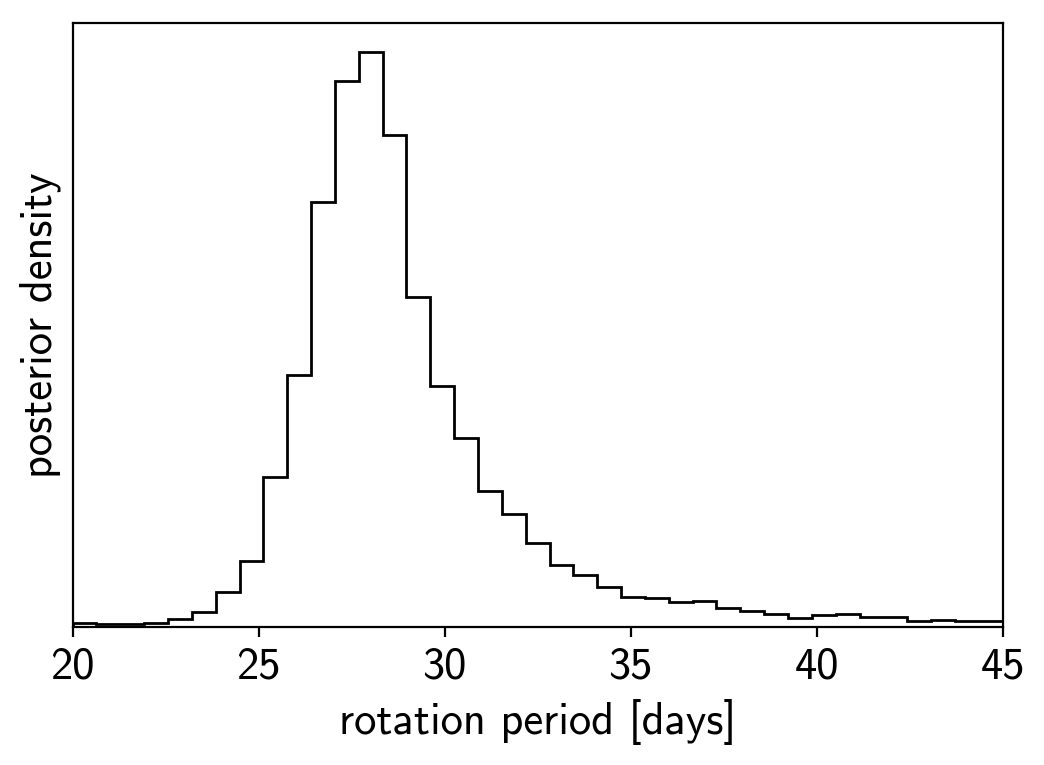

In [9]:
period_samples = trace["period"]
bins = np.linspace(20, 45, 40)
plt.hist(period_samples, bins, histtype="step", color="k")
plt.yticks([])
plt.xlim(bins.min(), bins.max())
plt.xlabel("rotation period [days]")
plt.ylabel("posterior density");